In [1]:
import numpy as np
import cv2,time,glob
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline

def ReadOImgs(root):
    import os
    datalist=[]
    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.endswith('.png') or name.endswith('.jpeg'):
                imgpath=os.path.join(path, name)
                datalist.append(imgpath)
    return datalist

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if file.endswith('.jpeg'):
            image = image.astype(np.float32)/255 
        else:
            image = image.astype(np.float32)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

C:\Program Files\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cars=ReadOImgs("./data/vehicles")
notcars=ReadOImgs("./data/non-vehicles")
print("Raw data about cars & notcars")
print(len(cars))
print(len(notcars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 800
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


Raw data about cars & notcars
8792
1125


In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 26    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [420, 740] # Min and max in y to search in slide_window()

In [4]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print("carfeature shape:",len(car_features))
print("ncrfeature shape:",len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(max_iter=15000)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Linear SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

carfeature shape: 800
ncrfeature shape: 800
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 5910
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9969
Linear SVC predicts:  [ 1.  0.  0.  0.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  1.  0.  1.  1.  0.]


In [5]:
def testdraw(img):
    testimage = mpimg.imread(img)
    draw_image = np.copy(testimage)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    testimage = testimage.astype(np.float32)/255

    windows = slide_window(testimage, x_start_stop=[400, 1300], y_start_stop=y_start_stop, 
                        xy_window=(90,90), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(testimage, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)

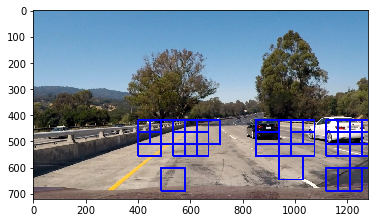

In [6]:
testdraw('./test_images/test1.jpg')

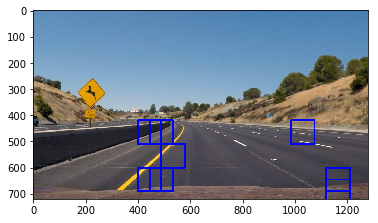

In [7]:
testdraw('./test_images/test2.jpg')

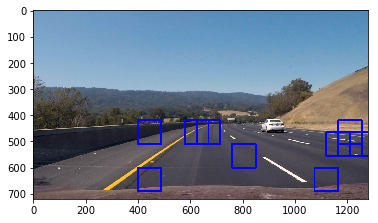

In [8]:
testdraw('./test_images/test3.jpg')

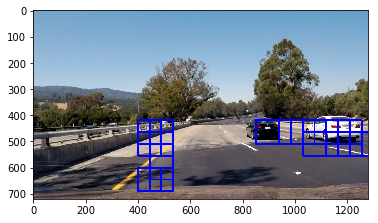

In [9]:
testdraw('./test_images/test4.jpg')

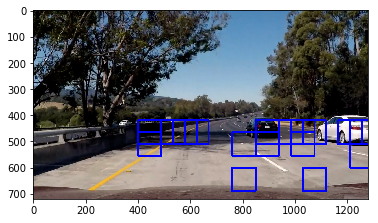

In [10]:
testdraw('./test_images/test5.jpg')

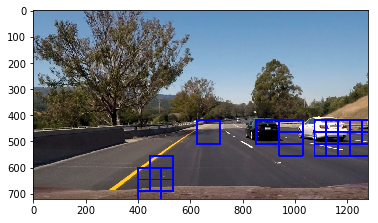

In [11]:
testdraw('./test_images/test6.jpg')

In [12]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    global bboxes_list

    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

def add_bboxes_to_list(image):
    return add_bboxes(image, windows, svc, X_scaler)
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    # Add bounding boxes from this frame
    add_bboxes(image, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    # Construct heatmap
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    # Label regions
    labels = label(frame_heatmap)
    
    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

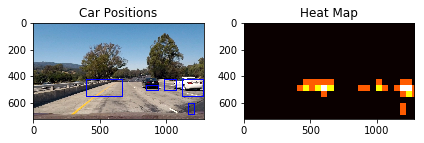

In [13]:
from scipy.ndimage.measurements import label
image = mpimg.imread('./test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
draw_image = np.copy(image)
testimage = image.astype(np.float32)/255
windows = slide_window(testimage, x_start_stop=[400, 1300], y_start_stop=y_start_stop, 
                        xy_window=(90,90), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(testimage, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 


# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

Hot windows:  []
[MoviePy] >>>> Building video output_v5.mp4
[MoviePy] Writing video output_v5.mp4


  0%|                                                     | 0/1261 [00:00<?, ?it/s]

Hot windows:  []


  0%|                                             | 1/1261 [00:00<07:27,  2.81it/s]

Hot windows:  []


  0%|                                             | 2/1261 [00:00<07:28,  2.81it/s]

Hot windows:  []


  0%|                                             | 3/1261 [00:01<07:29,  2.80it/s]

Hot windows:  [((400, 600), (490, 690))]


  0%|▏                                            | 4/1261 [00:01<07:42,  2.72it/s]

Hot windows:  [((400, 600), (490, 690))]


  0%|▏                                            | 5/1261 [00:01<07:36,  2.75it/s]

Hot windows:  []


  0%|▏                                            | 6/1261 [00:02<07:42,  2.71it/s]

Hot windows:  []


  1%|▏                                            | 7/1261 [00:02<07:45,  2.69it/s]

Hot windows:  []


  1%|▎                                            | 8/1261 [00:02<07:42,  2.71it/s]

Hot windows:  []


  1%|▎                                            | 9/1261 [00:03<07:54,  2.64it/s]

Hot windows:  []


  1%|▎                                           | 10/1261 [00:03<07:54,  2.63it/s]

Hot windows:  []


  1%|▍                                           | 11/1261 [00:04<07:44,  2.69it/s]

Hot windows:  []


  1%|▍                                           | 12/1261 [00:04<07:56,  2.62it/s]

Hot windows:  []


  1%|▍                                           | 13/1261 [00:04<07:43,  2.69it/s]

Hot windows:  []


  1%|▍                                           | 14/1261 [00:05<07:56,  2.62it/s]

Hot windows:  [((400, 600), (490, 690))]


  1%|▌                                           | 15/1261 [00:05<07:47,  2.66it/s]

Hot windows:  []


  1%|▌                                           | 16/1261 [00:05<07:39,  2.71it/s]

Hot windows:  []


  1%|▌                                           | 17/1261 [00:06<07:35,  2.73it/s]

Hot windows:  []


  1%|▋                                           | 18/1261 [00:06<07:58,  2.60it/s]

Hot windows:  []


  2%|▋                                           | 19/1261 [00:07<07:56,  2.61it/s]

Hot windows:  []


  2%|▋                                           | 20/1261 [00:07<07:55,  2.61it/s]

Hot windows:  []


  2%|▋                                           | 21/1261 [00:07<07:46,  2.66it/s]

Hot windows:  []


  2%|▊                                           | 22/1261 [00:08<07:59,  2.58it/s]

Hot windows:  []


  2%|▊                                           | 23/1261 [00:08<07:49,  2.64it/s]

Hot windows:  []


  2%|▊                                           | 24/1261 [00:08<07:43,  2.67it/s]

Hot windows:  []


  2%|▊                                           | 25/1261 [00:09<07:36,  2.71it/s]

Hot windows:  []


  2%|▉                                           | 26/1261 [00:09<07:29,  2.74it/s]

Hot windows:  []


  2%|▉                                           | 27/1261 [00:10<07:27,  2.75it/s]

Hot windows:  []


  2%|▉                                           | 28/1261 [00:10<07:23,  2.78it/s]

Hot windows:  []


  2%|█                                           | 29/1261 [00:10<07:24,  2.77it/s]

Hot windows:  []


  2%|█                                           | 30/1261 [00:11<07:22,  2.78it/s]

Hot windows:  []


  2%|█                                           | 31/1261 [00:11<07:24,  2.77it/s]

Hot windows:  []


  3%|█                                           | 32/1261 [00:11<07:33,  2.71it/s]

Hot windows:  []


  3%|█▏                                          | 33/1261 [00:12<07:23,  2.77it/s]

Hot windows:  []


  3%|█▏                                          | 34/1261 [00:12<07:17,  2.81it/s]

Hot windows:  []


  3%|█▏                                          | 35/1261 [00:12<07:17,  2.80it/s]

Hot windows:  []


  3%|█▎                                          | 36/1261 [00:13<07:25,  2.75it/s]

Hot windows:  []


  3%|█▎                                          | 37/1261 [00:13<07:26,  2.74it/s]

Hot windows:  []


  3%|█▎                                          | 38/1261 [00:14<07:31,  2.71it/s]

Hot windows:  []


  3%|█▎                                          | 39/1261 [00:14<07:24,  2.75it/s]

Hot windows:  []


  3%|█▍                                          | 40/1261 [00:14<07:22,  2.76it/s]

Hot windows:  []


  3%|█▍                                          | 41/1261 [00:15<07:17,  2.79it/s]

Hot windows:  [((400, 600), (490, 690))]


  3%|█▍                                          | 42/1261 [00:15<07:16,  2.79it/s]

Hot windows:  [((400, 600), (490, 690))]


  3%|█▌                                          | 43/1261 [00:15<07:21,  2.76it/s]

Hot windows:  []


  3%|█▌                                          | 44/1261 [00:16<07:33,  2.68it/s]

Hot windows:  [((400, 600), (490, 690))]


  4%|█▌                                          | 45/1261 [00:16<07:32,  2.68it/s]

Hot windows:  []


  4%|█▌                                          | 46/1261 [00:17<07:47,  2.60it/s]

Hot windows:  []


  4%|█▋                                          | 47/1261 [00:17<07:42,  2.63it/s]

Hot windows:  []


  4%|█▋                                          | 48/1261 [00:17<07:44,  2.61it/s]

Hot windows:  []


  4%|█▋                                          | 49/1261 [00:18<07:44,  2.61it/s]

Hot windows:  []


  4%|█▋                                          | 50/1261 [00:18<07:33,  2.67it/s]

Hot windows:  []


  4%|█▊                                          | 51/1261 [00:18<07:26,  2.71it/s]

Hot windows:  []


  4%|█▊                                          | 52/1261 [00:19<07:32,  2.67it/s]

Hot windows:  []


  4%|█▊                                          | 53/1261 [00:19<07:33,  2.67it/s]

Hot windows:  []


  4%|█▉                                          | 54/1261 [00:20<07:24,  2.72it/s]

Hot windows:  []


  4%|█▉                                          | 55/1261 [00:20<07:19,  2.75it/s]

Hot windows:  []


  4%|█▉                                          | 56/1261 [00:20<07:14,  2.77it/s]

Hot windows:  []


  5%|█▉                                          | 57/1261 [00:21<07:09,  2.81it/s]

Hot windows:  []


  5%|██                                          | 58/1261 [00:21<07:10,  2.79it/s]

Hot windows:  []


  5%|██                                          | 59/1261 [00:21<07:08,  2.80it/s]

Hot windows:  []


  5%|██                                          | 60/1261 [00:22<07:23,  2.71it/s]

Hot windows:  []


  5%|██▏                                         | 61/1261 [00:22<07:17,  2.74it/s]

Hot windows:  []


  5%|██▏                                         | 62/1261 [00:22<07:10,  2.79it/s]

Hot windows:  []


  5%|██▏                                         | 63/1261 [00:23<07:08,  2.80it/s]

Hot windows:  []


  5%|██▏                                         | 64/1261 [00:23<07:06,  2.81it/s]

Hot windows:  []


  5%|██▎                                         | 65/1261 [00:23<07:03,  2.83it/s]

Hot windows:  []


  5%|██▎                                         | 66/1261 [00:24<07:04,  2.81it/s]

Hot windows:  []


  5%|██▎                                         | 67/1261 [00:24<07:05,  2.80it/s]

Hot windows:  []


  5%|██▎                                         | 68/1261 [00:25<07:07,  2.79it/s]

Hot windows:  []


  5%|██▍                                         | 69/1261 [00:25<07:03,  2.81it/s]

Hot windows:  []


  6%|██▍                                         | 70/1261 [00:25<07:04,  2.80it/s]

Hot windows:  []


  6%|██▍                                         | 71/1261 [00:26<07:04,  2.80it/s]

Hot windows:  []


  6%|██▌                                         | 72/1261 [00:26<07:06,  2.79it/s]

Hot windows:  []


  6%|██▌                                         | 73/1261 [00:26<07:04,  2.80it/s]

Hot windows:  []


  6%|██▌                                         | 74/1261 [00:27<07:23,  2.68it/s]

Hot windows:  []


  6%|██▌                                         | 75/1261 [00:27<07:14,  2.73it/s]

Hot windows:  []


  6%|██▋                                         | 76/1261 [00:27<07:10,  2.76it/s]

Hot windows:  []


  6%|██▋                                         | 77/1261 [00:28<07:05,  2.78it/s]

Hot windows:  []


  6%|██▋                                         | 78/1261 [00:28<07:27,  2.64it/s]

Hot windows:  []


  6%|██▊                                         | 79/1261 [00:29<07:20,  2.68it/s]

Hot windows:  []


  6%|██▊                                         | 80/1261 [00:29<07:12,  2.73it/s]

Hot windows:  []


  6%|██▊                                         | 81/1261 [00:29<07:08,  2.75it/s]

Hot windows:  []


  7%|██▊                                         | 82/1261 [00:30<07:03,  2.78it/s]

Hot windows:  []


  7%|██▉                                         | 83/1261 [00:30<07:03,  2.78it/s]

Hot windows:  []


  7%|██▉                                         | 84/1261 [00:30<07:06,  2.76it/s]

Hot windows:  []


  7%|██▉                                         | 85/1261 [00:31<07:20,  2.67it/s]

Hot windows:  []


  7%|███                                         | 86/1261 [00:31<07:13,  2.71it/s]

Hot windows:  []


  7%|███                                         | 87/1261 [00:31<07:06,  2.75it/s]

Hot windows:  []


  7%|███                                         | 88/1261 [00:32<07:26,  2.63it/s]

Hot windows:  []


  7%|███                                         | 89/1261 [00:32<07:22,  2.65it/s]

Hot windows:  []


  7%|███▏                                        | 90/1261 [00:33<07:30,  2.60it/s]

Hot windows:  []


  7%|███▏                                        | 91/1261 [00:33<07:20,  2.65it/s]

Hot windows:  []


  7%|███▏                                        | 92/1261 [00:33<07:27,  2.61it/s]

Hot windows:  []


  7%|███▏                                        | 93/1261 [00:34<07:32,  2.58it/s]

Hot windows:  []


  7%|███▎                                        | 94/1261 [00:34<07:19,  2.66it/s]

Hot windows:  []


  8%|███▎                                        | 95/1261 [00:34<07:11,  2.70it/s]

Hot windows:  []


  8%|███▎                                        | 96/1261 [00:35<07:06,  2.73it/s]

Hot windows:  []


  8%|███▍                                        | 97/1261 [00:35<07:21,  2.63it/s]

Hot windows:  []


  8%|███▍                                        | 98/1261 [00:36<07:22,  2.63it/s]

Hot windows:  []


  8%|███▍                                        | 99/1261 [00:36<07:37,  2.54it/s]

Hot windows:  []


  8%|███▍                                       | 100/1261 [00:36<07:25,  2.61it/s]

Hot windows:  []


  8%|███▍                                       | 101/1261 [00:37<07:37,  2.53it/s]

Hot windows:  []


  8%|███▍                                       | 102/1261 [00:37<07:46,  2.48it/s]

Hot windows:  []


  8%|███▌                                       | 103/1261 [00:38<07:33,  2.55it/s]

Hot windows:  []


  8%|███▌                                       | 104/1261 [00:38<07:21,  2.62it/s]

Hot windows:  []


  8%|███▌                                       | 105/1261 [00:38<07:20,  2.62it/s]

Hot windows:  []


  8%|███▌                                       | 106/1261 [00:39<07:13,  2.66it/s]

Hot windows:  []


  8%|███▋                                       | 107/1261 [00:39<07:04,  2.72it/s]

Hot windows:  []


  9%|███▋                                       | 108/1261 [00:39<06:58,  2.75it/s]

Hot windows:  []


  9%|███▋                                       | 109/1261 [00:40<06:53,  2.79it/s]

Hot windows:  []


  9%|███▊                                       | 110/1261 [00:40<06:51,  2.79it/s]

Hot windows:  []


  9%|███▊                                       | 111/1261 [00:40<06:49,  2.81it/s]

Hot windows:  []


  9%|███▊                                       | 112/1261 [00:41<06:50,  2.80it/s]

Hot windows:  []


  9%|███▊                                       | 113/1261 [00:41<07:02,  2.72it/s]

Hot windows:  []


  9%|███▉                                       | 114/1261 [00:42<07:12,  2.65it/s]

Hot windows:  []


  9%|███▉                                       | 115/1261 [00:42<07:34,  2.52it/s]

Hot windows:  []


  9%|███▉                                       | 116/1261 [00:42<07:20,  2.60it/s]

Hot windows:  []


  9%|███▉                                       | 117/1261 [00:43<07:20,  2.60it/s]

Hot windows:  []


  9%|████                                       | 118/1261 [00:43<07:16,  2.62it/s]

Hot windows:  []


  9%|████                                       | 119/1261 [00:44<07:17,  2.61it/s]

Hot windows:  []


 10%|████                                       | 120/1261 [00:44<07:20,  2.59it/s]

Hot windows:  []


 10%|████▏                                      | 121/1261 [00:44<07:18,  2.60it/s]

Hot windows:  []


 10%|████▏                                      | 122/1261 [00:45<07:11,  2.64it/s]

Hot windows:  []


 10%|████▏                                      | 123/1261 [00:45<07:08,  2.66it/s]

Hot windows:  []


 10%|████▏                                      | 124/1261 [00:45<07:13,  2.62it/s]

Hot windows:  []


 10%|████▎                                      | 125/1261 [00:46<07:03,  2.68it/s]

Hot windows:  []


 10%|████▎                                      | 126/1261 [00:46<07:13,  2.62it/s]

Hot windows:  []


 10%|████▎                                      | 127/1261 [00:47<07:21,  2.57it/s]

Hot windows:  []


 10%|████▎                                      | 128/1261 [00:47<07:27,  2.53it/s]

Hot windows:  []


 10%|████▍                                      | 129/1261 [00:47<07:22,  2.56it/s]

Hot windows:  []


 10%|████▍                                      | 130/1261 [00:48<07:10,  2.63it/s]

Hot windows:  []


 10%|████▍                                      | 131/1261 [00:48<07:15,  2.60it/s]

Hot windows:  []


 10%|████▌                                      | 132/1261 [00:49<07:18,  2.57it/s]

Hot windows:  []


 11%|████▌                                      | 133/1261 [00:49<07:11,  2.61it/s]

Hot windows:  []


 11%|████▌                                      | 134/1261 [00:49<07:03,  2.66it/s]

Hot windows:  []


 11%|████▌                                      | 135/1261 [00:50<06:57,  2.69it/s]

Hot windows:  []


 11%|████▋                                      | 136/1261 [00:50<06:54,  2.71it/s]

Hot windows:  [((400, 600), (490, 690))]


 11%|████▋                                      | 137/1261 [00:50<06:49,  2.75it/s]

Hot windows:  []


 11%|████▋                                      | 138/1261 [00:51<06:44,  2.78it/s]

Hot windows:  []


 11%|████▋                                      | 139/1261 [00:51<06:46,  2.76it/s]

Hot windows:  [((400, 600), (490, 690))]


 11%|████▊                                      | 140/1261 [00:52<06:54,  2.70it/s]

Hot windows:  []


 11%|████▊                                      | 141/1261 [00:52<06:50,  2.73it/s]

Hot windows:  [((400, 420), (490, 510))]


 11%|████▊                                      | 142/1261 [00:52<07:08,  2.61it/s]

Hot windows:  []


 11%|████▉                                      | 143/1261 [00:53<07:10,  2.60it/s]

Hot windows:  []


 11%|████▉                                      | 144/1261 [00:53<07:04,  2.63it/s]

Hot windows:  []


 11%|████▉                                      | 145/1261 [00:53<07:01,  2.65it/s]

Hot windows:  []


 12%|████▉                                      | 146/1261 [00:54<06:59,  2.66it/s]

Hot windows:  []


 12%|█████                                      | 147/1261 [00:54<06:53,  2.69it/s]

Hot windows:  []


 12%|█████                                      | 148/1261 [00:55<06:49,  2.71it/s]

Hot windows:  []


 12%|█████                                      | 149/1261 [00:55<06:44,  2.75it/s]

Hot windows:  []


 12%|█████                                      | 150/1261 [00:55<06:41,  2.77it/s]

Hot windows:  []


 12%|█████▏                                     | 151/1261 [00:56<06:42,  2.76it/s]

Hot windows:  []


 12%|█████▏                                     | 152/1261 [00:56<06:49,  2.71it/s]

Hot windows:  []


 12%|█████▏                                     | 153/1261 [00:56<07:03,  2.61it/s]

Hot windows:  []


 12%|█████▎                                     | 154/1261 [00:57<07:10,  2.57it/s]

Hot windows:  [((400, 600), (490, 690))]


 12%|█████▎                                     | 155/1261 [00:57<07:08,  2.58it/s]

Hot windows:  []


 12%|█████▎                                     | 156/1261 [00:58<07:19,  2.52it/s]

Hot windows:  []


 12%|█████▎                                     | 157/1261 [00:58<07:22,  2.50it/s]

Hot windows:  []


 13%|█████▍                                     | 158/1261 [00:58<07:13,  2.54it/s]

Hot windows:  []


 13%|█████▍                                     | 159/1261 [00:59<07:01,  2.61it/s]

Hot windows:  []


 13%|█████▍                                     | 160/1261 [00:59<06:49,  2.69it/s]

Hot windows:  []


 13%|█████▍                                     | 161/1261 [00:59<06:44,  2.72it/s]

Hot windows:  []


 13%|█████▌                                     | 162/1261 [01:00<06:41,  2.74it/s]

Hot windows:  []


 13%|█████▌                                     | 163/1261 [01:00<06:35,  2.78it/s]

Hot windows:  []


 13%|█████▌                                     | 164/1261 [01:00<06:31,  2.80it/s]

Hot windows:  []


 13%|█████▋                                     | 165/1261 [01:01<06:36,  2.77it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 13%|█████▋                                     | 166/1261 [01:01<06:35,  2.77it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 13%|█████▋                                     | 167/1261 [01:02<06:33,  2.78it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 13%|█████▋                                     | 168/1261 [01:02<06:36,  2.76it/s]

Hot windows:  []


 13%|█████▊                                     | 169/1261 [01:02<06:36,  2.75it/s]

Hot windows:  []


 13%|█████▊                                     | 170/1261 [01:03<06:55,  2.63it/s]

Hot windows:  []


 14%|█████▊                                     | 171/1261 [01:03<06:49,  2.66it/s]

Hot windows:  []


 14%|█████▊                                     | 172/1261 [01:03<06:46,  2.68it/s]

Hot windows:  []


 14%|█████▉                                     | 173/1261 [01:04<06:42,  2.70it/s]

Hot windows:  []


 14%|█████▉                                     | 174/1261 [01:04<06:40,  2.71it/s]

Hot windows:  []


 14%|█████▉                                     | 175/1261 [01:05<06:39,  2.72it/s]

Hot windows:  []


 14%|██████                                     | 176/1261 [01:05<06:42,  2.69it/s]

Hot windows:  []


 14%|██████                                     | 177/1261 [01:05<06:40,  2.71it/s]

Hot windows:  []


 14%|██████                                     | 178/1261 [01:06<06:40,  2.71it/s]

Hot windows:  []


 14%|██████                                     | 179/1261 [01:06<06:35,  2.74it/s]

Hot windows:  []


 14%|██████▏                                    | 180/1261 [01:06<06:33,  2.75it/s]

Hot windows:  []


 14%|██████▏                                    | 181/1261 [01:07<06:34,  2.74it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 14%|██████▏                                    | 182/1261 [01:07<06:41,  2.69it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 15%|██████▏                                    | 183/1261 [01:08<06:39,  2.70it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 15%|██████▎                                    | 184/1261 [01:08<06:51,  2.62it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 15%|██████▎                                    | 185/1261 [01:08<06:45,  2.65it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 15%|██████▎                                    | 186/1261 [01:09<06:40,  2.68it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 15%|██████▍                                    | 187/1261 [01:09<06:34,  2.72it/s]

Hot windows:  [((1120, 420), (1210, 510)), ((1210, 420), (1300, 510))]


 15%|██████▍                                    | 188/1261 [01:09<06:35,  2.72it/s]

Hot windows:  [((1120, 420), (1210, 510)), ((1210, 420), (1300, 510))]


 15%|██████▍                                    | 189/1261 [01:10<06:37,  2.70it/s]

Hot windows:  [((1120, 420), (1210, 510)), ((1210, 420), (1300, 510))]


 15%|██████▍                                    | 190/1261 [01:10<06:43,  2.66it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 15%|██████▌                                    | 191/1261 [01:11<06:41,  2.67it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 15%|██████▌                                    | 192/1261 [01:11<06:35,  2.71it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 15%|██████▌                                    | 193/1261 [01:11<06:32,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 15%|██████▌                                    | 194/1261 [01:12<06:32,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 15%|██████▋                                    | 195/1261 [01:12<06:34,  2.71it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 16%|██████▋                                    | 196/1261 [01:12<06:31,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 16%|██████▋                                    | 197/1261 [01:13<06:56,  2.55it/s]

Hot windows:  []


 16%|██████▊                                    | 198/1261 [01:13<07:03,  2.51it/s]

Hot windows:  []


 16%|██████▊                                    | 199/1261 [01:14<06:54,  2.56it/s]

Hot windows:  []


 16%|██████▊                                    | 200/1261 [01:14<06:48,  2.60it/s]

Hot windows:  []


 16%|██████▊                                    | 201/1261 [01:14<06:40,  2.65it/s]

Hot windows:  []


 16%|██████▉                                    | 202/1261 [01:15<06:56,  2.54it/s]

Hot windows:  []


 16%|██████▉                                    | 203/1261 [01:15<07:02,  2.50it/s]

Hot windows:  []


 16%|██████▉                                    | 204/1261 [01:16<06:53,  2.56it/s]

Hot windows:  []


 16%|██████▉                                    | 205/1261 [01:16<06:47,  2.59it/s]

Hot windows:  []


 16%|███████                                    | 206/1261 [01:16<06:40,  2.63it/s]

Hot windows:  []


 16%|███████                                    | 207/1261 [01:17<06:39,  2.64it/s]

Hot windows:  []


 16%|███████                                    | 208/1261 [01:17<06:45,  2.60it/s]

Hot windows:  []


 17%|███████▏                                   | 209/1261 [01:17<06:39,  2.63it/s]

Hot windows:  []


 17%|███████▏                                   | 210/1261 [01:18<06:35,  2.66it/s]

Hot windows:  []


 17%|███████▏                                   | 211/1261 [01:18<06:48,  2.57it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 17%|███████▏                                   | 212/1261 [01:19<06:44,  2.59it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 17%|███████▎                                   | 213/1261 [01:19<06:39,  2.62it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 17%|███████▎                                   | 214/1261 [01:19<06:39,  2.62it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▎                                   | 215/1261 [01:20<06:36,  2.64it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▎                                   | 216/1261 [01:20<06:38,  2.62it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▍                                   | 217/1261 [01:20<06:33,  2.65it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▍                                   | 218/1261 [01:21<06:31,  2.67it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▍                                   | 219/1261 [01:21<06:24,  2.71it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 17%|███████▌                                   | 220/1261 [01:22<06:25,  2.70it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 18%|███████▌                                   | 221/1261 [01:22<06:27,  2.68it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 18%|███████▌                                   | 222/1261 [01:22<06:31,  2.66it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▌                                   | 223/1261 [01:23<06:37,  2.61it/s]

Hot windows:  [((985, 420), (1075, 510)), ((1075, 420), (1165, 510))]


 18%|███████▋                                   | 224/1261 [01:23<06:55,  2.50it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▋                                   | 225/1261 [01:24<06:49,  2.53it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▋                                   | 226/1261 [01:24<06:43,  2.57it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▋                                   | 227/1261 [01:24<06:40,  2.58it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▊                                   | 228/1261 [01:25<06:36,  2.60it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▊                                   | 229/1261 [01:25<06:35,  2.61it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▊                                   | 230/1261 [01:25<06:28,  2.65it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▉                                   | 231/1261 [01:26<06:28,  2.65it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▉                                   | 232/1261 [01:26<06:28,  2.65it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 18%|███████▉                                   | 233/1261 [01:27<06:30,  2.63it/s]

Hot windows:  []


 19%|███████▉                                   | 234/1261 [01:27<06:33,  2.61it/s]

Hot windows:  []


 19%|████████                                   | 235/1261 [01:27<06:29,  2.63it/s]

Hot windows:  []


 19%|████████                                   | 236/1261 [01:28<06:21,  2.69it/s]

Hot windows:  []


 19%|████████                                   | 237/1261 [01:28<06:21,  2.68it/s]

Hot windows:  []


 19%|████████                                   | 238/1261 [01:28<06:37,  2.58it/s]

Hot windows:  []


 19%|████████▏                                  | 239/1261 [01:29<06:28,  2.63it/s]

Hot windows:  []


 19%|████████▏                                  | 240/1261 [01:29<06:22,  2.67it/s]

Hot windows:  []


 19%|████████▏                                  | 241/1261 [01:30<06:21,  2.68it/s]

Hot windows:  []


 19%|████████▎                                  | 242/1261 [01:30<06:17,  2.70it/s]

Hot windows:  []


 19%|████████▎                                  | 243/1261 [01:30<06:12,  2.73it/s]

Hot windows:  []


 19%|████████▎                                  | 244/1261 [01:31<06:12,  2.73it/s]

Hot windows:  []


 19%|████████▎                                  | 245/1261 [01:31<06:10,  2.74it/s]

Hot windows:  []


 20%|████████▍                                  | 246/1261 [01:31<06:07,  2.76it/s]

Hot windows:  []


 20%|████████▍                                  | 247/1261 [01:32<06:10,  2.74it/s]

Hot windows:  []


 20%|████████▍                                  | 248/1261 [01:32<06:07,  2.76it/s]

Hot windows:  []


 20%|████████▍                                  | 249/1261 [01:32<06:03,  2.78it/s]

Hot windows:  []


 20%|████████▌                                  | 250/1261 [01:33<06:08,  2.74it/s]

Hot windows:  []


 20%|████████▌                                  | 251/1261 [01:33<06:08,  2.74it/s]

Hot windows:  []


 20%|████████▌                                  | 252/1261 [01:34<06:27,  2.61it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▋                                  | 253/1261 [01:34<06:26,  2.61it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▋                                  | 254/1261 [01:34<06:18,  2.66it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▋                                  | 255/1261 [01:35<06:13,  2.70it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▋                                  | 256/1261 [01:35<06:08,  2.73it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▊                                  | 257/1261 [01:35<06:15,  2.67it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 20%|████████▊                                  | 258/1261 [01:36<06:15,  2.67it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|████████▊                                  | 259/1261 [01:36<06:13,  2.68it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|████████▊                                  | 260/1261 [01:37<06:16,  2.66it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|████████▉                                  | 261/1261 [01:37<06:11,  2.69it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|████████▉                                  | 262/1261 [01:37<06:10,  2.70it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|████████▉                                  | 263/1261 [01:38<06:12,  2.68it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████                                  | 264/1261 [01:38<06:17,  2.64it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████                                  | 265/1261 [01:38<06:23,  2.60it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████                                  | 266/1261 [01:39<06:19,  2.62it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████                                  | 267/1261 [01:39<06:13,  2.66it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████▏                                 | 268/1261 [01:40<06:07,  2.70it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████▏                                 | 269/1261 [01:40<06:05,  2.71it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████▏                                 | 270/1261 [01:40<06:14,  2.65it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 21%|█████████▏                                 | 271/1261 [01:41<06:09,  2.68it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▎                                 | 272/1261 [01:41<06:07,  2.69it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▎                                 | 273/1261 [01:41<06:05,  2.71it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▎                                 | 274/1261 [01:42<06:02,  2.72it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▍                                 | 275/1261 [01:42<06:17,  2.61it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▍                                 | 276/1261 [01:43<06:24,  2.56it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▍                                 | 277/1261 [01:43<06:13,  2.63it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▍                                 | 278/1261 [01:43<06:10,  2.65it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▌                                 | 279/1261 [01:44<06:20,  2.58it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▌                                 | 280/1261 [01:44<06:16,  2.61it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▌                                 | 281/1261 [01:45<06:07,  2.67it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 22%|█████████▌                                 | 282/1261 [01:45<06:07,  2.67it/s]

Hot windows:  []


 22%|█████████▋                                 | 283/1261 [01:45<06:06,  2.67it/s]

Hot windows:  []


 23%|█████████▋                                 | 284/1261 [01:46<06:03,  2.69it/s]

Hot windows:  []


 23%|█████████▋                                 | 285/1261 [01:46<06:02,  2.69it/s]

Hot windows:  []


 23%|█████████▊                                 | 286/1261 [01:46<06:02,  2.69it/s]

Hot windows:  []


 23%|█████████▊                                 | 287/1261 [01:47<06:01,  2.70it/s]

Hot windows:  []


 23%|█████████▊                                 | 288/1261 [01:47<06:03,  2.68it/s]

Hot windows:  []


 23%|█████████▊                                 | 289/1261 [01:47<05:57,  2.72it/s]

Hot windows:  []


 23%|█████████▉                                 | 290/1261 [01:48<05:56,  2.72it/s]

Hot windows:  []


 23%|█████████▉                                 | 291/1261 [01:48<05:54,  2.73it/s]

Hot windows:  []


 23%|█████████▉                                 | 292/1261 [01:49<05:54,  2.74it/s]

Hot windows:  []


 23%|█████████▉                                 | 293/1261 [01:49<06:07,  2.64it/s]

Hot windows:  []


 23%|██████████                                 | 294/1261 [01:49<06:31,  2.47it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 23%|██████████                                 | 295/1261 [01:50<06:36,  2.44it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 23%|██████████                                 | 296/1261 [01:50<06:26,  2.50it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 24%|██████████▏                                | 297/1261 [01:51<06:17,  2.55it/s]

Hot windows:  []


 24%|██████████▏                                | 298/1261 [01:51<06:12,  2.59it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 24%|██████████▏                                | 299/1261 [01:51<06:07,  2.62it/s]

Hot windows:  []


 24%|██████████▏                                | 300/1261 [01:52<06:00,  2.66it/s]

Hot windows:  []


 24%|██████████▎                                | 301/1261 [01:52<05:58,  2.68it/s]

Hot windows:  []


 24%|██████████▎                                | 302/1261 [01:52<06:00,  2.66it/s]

Hot windows:  []


 24%|██████████▎                                | 303/1261 [01:53<06:07,  2.61it/s]

Hot windows:  []


 24%|██████████▎                                | 304/1261 [01:53<06:07,  2.60it/s]

Hot windows:  []


 24%|██████████▍                                | 305/1261 [01:54<06:24,  2.48it/s]

Hot windows:  []


 24%|██████████▍                                | 306/1261 [01:54<06:34,  2.42it/s]

Hot windows:  []


 24%|██████████▍                                | 307/1261 [01:55<06:34,  2.42it/s]

Hot windows:  []


 24%|██████████▌                                | 308/1261 [01:55<06:28,  2.46it/s]

Hot windows:  []


 25%|██████████▌                                | 309/1261 [01:55<06:23,  2.48it/s]

Hot windows:  []


 25%|██████████▌                                | 310/1261 [01:56<06:30,  2.43it/s]

Hot windows:  []


 25%|██████████▌                                | 311/1261 [01:56<06:29,  2.44it/s]

Hot windows:  []


 25%|██████████▋                                | 312/1261 [01:57<06:29,  2.43it/s]

Hot windows:  []


 25%|██████████▋                                | 313/1261 [01:57<06:15,  2.52it/s]

Hot windows:  []


 25%|██████████▋                                | 314/1261 [01:57<06:07,  2.58it/s]

Hot windows:  []


 25%|██████████▋                                | 315/1261 [01:58<05:57,  2.64it/s]

Hot windows:  []


 25%|██████████▊                                | 316/1261 [01:58<05:50,  2.69it/s]

Hot windows:  []


 25%|██████████▊                                | 317/1261 [01:58<05:49,  2.70it/s]

Hot windows:  []


 25%|██████████▊                                | 318/1261 [01:59<05:45,  2.73it/s]

Hot windows:  []


 25%|██████████▉                                | 319/1261 [01:59<06:00,  2.61it/s]

Hot windows:  []


 25%|██████████▉                                | 320/1261 [02:00<05:57,  2.63it/s]

Hot windows:  []


 25%|██████████▉                                | 321/1261 [02:00<05:51,  2.67it/s]

Hot windows:  []


 26%|██████████▉                                | 322/1261 [02:00<05:49,  2.69it/s]

Hot windows:  []


 26%|███████████                                | 323/1261 [02:01<05:43,  2.73it/s]

Hot windows:  []


 26%|███████████                                | 324/1261 [02:01<05:44,  2.72it/s]

Hot windows:  []


 26%|███████████                                | 325/1261 [02:01<05:41,  2.74it/s]

Hot windows:  []


 26%|███████████                                | 326/1261 [02:02<05:42,  2.73it/s]

Hot windows:  []


 26%|███████████▏                               | 327/1261 [02:02<05:39,  2.75it/s]

Hot windows:  []


 26%|███████████▏                               | 328/1261 [02:02<05:36,  2.77it/s]

Hot windows:  []


 26%|███████████▏                               | 329/1261 [02:03<05:34,  2.79it/s]

Hot windows:  []


 26%|███████████▎                               | 330/1261 [02:03<05:35,  2.77it/s]

Hot windows:  []


 26%|███████████▎                               | 331/1261 [02:04<05:37,  2.76it/s]

Hot windows:  []


 26%|███████████▎                               | 332/1261 [02:04<05:37,  2.76it/s]

Hot windows:  []


 26%|███████████▎                               | 333/1261 [02:04<05:51,  2.64it/s]

Hot windows:  [((985, 420), (1075, 510))]


 26%|███████████▍                               | 334/1261 [02:05<05:51,  2.64it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▍                               | 335/1261 [02:05<05:49,  2.65it/s]

Hot windows:  []


 27%|███████████▍                               | 336/1261 [02:05<05:54,  2.61it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▍                               | 337/1261 [02:06<05:51,  2.63it/s]

Hot windows:  []


 27%|███████████▌                               | 338/1261 [02:06<05:43,  2.69it/s]

Hot windows:  []


 27%|███████████▌                               | 339/1261 [02:07<05:39,  2.72it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▌                               | 340/1261 [02:07<05:37,  2.73it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▋                               | 341/1261 [02:07<05:36,  2.73it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▋                               | 342/1261 [02:08<05:35,  2.74it/s]

Hot windows:  [((985, 420), (1075, 510))]


 27%|███████████▋                               | 343/1261 [02:08<05:34,  2.75it/s]

Hot windows:  []


 27%|███████████▋                               | 344/1261 [02:08<05:33,  2.75it/s]

Hot windows:  []


 27%|███████████▊                               | 345/1261 [02:09<05:35,  2.73it/s]

Hot windows:  []


 27%|███████████▊                               | 346/1261 [02:09<05:39,  2.70it/s]

Hot windows:  []


 28%|███████████▊                               | 347/1261 [02:10<05:51,  2.60it/s]

Hot windows:  []


 28%|███████████▊                               | 348/1261 [02:10<05:47,  2.63it/s]

Hot windows:  []


 28%|███████████▉                               | 349/1261 [02:10<05:39,  2.69it/s]

Hot windows:  []


 28%|███████████▉                               | 350/1261 [02:11<05:46,  2.63it/s]

Hot windows:  []


 28%|███████████▉                               | 351/1261 [02:11<05:38,  2.69it/s]

Hot windows:  []


 28%|████████████                               | 352/1261 [02:11<05:33,  2.73it/s]

Hot windows:  []


 28%|████████████                               | 353/1261 [02:12<05:30,  2.74it/s]

Hot windows:  []


 28%|████████████                               | 354/1261 [02:12<05:28,  2.76it/s]

Hot windows:  []


 28%|████████████                               | 355/1261 [02:12<05:26,  2.77it/s]

Hot windows:  []


 28%|████████████▏                              | 356/1261 [02:13<05:23,  2.80it/s]

Hot windows:  []


 28%|████████████▏                              | 357/1261 [02:13<05:25,  2.78it/s]

Hot windows:  []


 28%|████████████▏                              | 358/1261 [02:13<05:23,  2.79it/s]

Hot windows:  []


 28%|████████████▏                              | 359/1261 [02:14<05:21,  2.81it/s]

Hot windows:  []


 29%|████████████▎                              | 360/1261 [02:14<05:22,  2.79it/s]

Hot windows:  []


 29%|████████████▎                              | 361/1261 [02:15<05:35,  2.69it/s]

Hot windows:  []


 29%|████████████▎                              | 362/1261 [02:15<05:31,  2.71it/s]

Hot windows:  []


 29%|████████████▍                              | 363/1261 [02:15<05:24,  2.77it/s]

Hot windows:  []


 29%|████████████▍                              | 364/1261 [02:16<05:22,  2.78it/s]

Hot windows:  []


 29%|████████████▍                              | 365/1261 [02:16<05:19,  2.81it/s]

Hot windows:  []


 29%|████████████▍                              | 366/1261 [02:16<05:19,  2.80it/s]

Hot windows:  []


 29%|████████████▌                              | 367/1261 [02:17<05:15,  2.83it/s]

Hot windows:  []


 29%|████████████▌                              | 368/1261 [02:17<05:14,  2.84it/s]

Hot windows:  []


 29%|████████████▌                              | 369/1261 [02:17<05:13,  2.84it/s]

Hot windows:  []


 29%|████████████▌                              | 370/1261 [02:18<05:14,  2.83it/s]

Hot windows:  []


 29%|████████████▋                              | 371/1261 [02:18<05:14,  2.83it/s]

Hot windows:  []


 30%|████████████▋                              | 372/1261 [02:18<05:15,  2.82it/s]

Hot windows:  []


 30%|████████████▋                              | 373/1261 [02:19<05:15,  2.81it/s]

Hot windows:  []


 30%|████████████▊                              | 374/1261 [02:19<05:17,  2.80it/s]

Hot windows:  []


 30%|████████████▊                              | 375/1261 [02:20<05:30,  2.68it/s]

Hot windows:  []


 30%|████████████▊                              | 376/1261 [02:20<05:28,  2.70it/s]

Hot windows:  []


 30%|████████████▊                              | 377/1261 [02:20<05:22,  2.74it/s]

Hot windows:  []


 30%|████████████▉                              | 378/1261 [02:21<05:20,  2.76it/s]

Hot windows:  []


 30%|████████████▉                              | 379/1261 [02:21<05:21,  2.75it/s]

Hot windows:  []


 30%|████████████▉                              | 380/1261 [02:21<05:21,  2.74it/s]

Hot windows:  []


 30%|████████████▉                              | 381/1261 [02:22<05:18,  2.76it/s]

Hot windows:  []


 30%|█████████████                              | 382/1261 [02:22<05:16,  2.78it/s]

Hot windows:  []


 30%|█████████████                              | 383/1261 [02:23<05:16,  2.77it/s]

Hot windows:  []


 30%|█████████████                              | 384/1261 [02:23<05:18,  2.75it/s]

Hot windows:  []


 31%|█████████████▏                             | 385/1261 [02:23<05:18,  2.75it/s]

Hot windows:  []


 31%|█████████████▏                             | 386/1261 [02:24<05:15,  2.78it/s]

Hot windows:  []


 31%|█████████████▏                             | 387/1261 [02:24<05:15,  2.77it/s]

Hot windows:  []


 31%|█████████████▏                             | 388/1261 [02:24<05:15,  2.76it/s]

Hot windows:  []


 31%|█████████████▎                             | 389/1261 [02:25<05:24,  2.69it/s]

Hot windows:  []


 31%|█████████████▎                             | 390/1261 [02:25<05:24,  2.68it/s]

Hot windows:  []


 31%|█████████████▎                             | 391/1261 [02:25<05:23,  2.69it/s]

Hot windows:  []


 31%|█████████████▎                             | 392/1261 [02:26<05:18,  2.73it/s]

Hot windows:  []


 31%|█████████████▍                             | 393/1261 [02:26<05:15,  2.75it/s]

Hot windows:  []


 31%|█████████████▍                             | 394/1261 [02:27<05:17,  2.73it/s]

Hot windows:  []


 31%|█████████████▍                             | 395/1261 [02:27<05:12,  2.77it/s]

Hot windows:  []


 31%|█████████████▌                             | 396/1261 [02:27<05:08,  2.80it/s]

Hot windows:  []


 31%|█████████████▌                             | 397/1261 [02:28<05:08,  2.81it/s]

Hot windows:  []


 32%|█████████████▌                             | 398/1261 [02:28<05:07,  2.81it/s]

Hot windows:  []


 32%|█████████████▌                             | 399/1261 [02:28<05:06,  2.81it/s]

Hot windows:  []


 32%|█████████████▋                             | 400/1261 [02:29<05:04,  2.82it/s]

Hot windows:  []


 32%|█████████████▋                             | 401/1261 [02:29<05:02,  2.84it/s]

Hot windows:  []


 32%|█████████████▋                             | 402/1261 [02:29<05:03,  2.83it/s]

Hot windows:  []


 32%|█████████████▋                             | 403/1261 [02:30<05:01,  2.84it/s]

Hot windows:  []


 32%|█████████████▊                             | 404/1261 [02:30<05:18,  2.69it/s]

Hot windows:  []


 32%|█████████████▊                             | 405/1261 [02:30<05:10,  2.75it/s]

Hot windows:  []


 32%|█████████████▊                             | 406/1261 [02:31<05:07,  2.78it/s]

Hot windows:  []


 32%|█████████████▉                             | 407/1261 [02:31<05:04,  2.80it/s]

Hot windows:  []


 32%|█████████████▉                             | 408/1261 [02:32<05:01,  2.83it/s]

Hot windows:  []


 32%|█████████████▉                             | 409/1261 [02:32<05:00,  2.83it/s]

Hot windows:  []


 33%|█████████████▉                             | 410/1261 [02:32<05:00,  2.83it/s]

Hot windows:  []


 33%|██████████████                             | 411/1261 [02:33<04:57,  2.85it/s]

Hot windows:  []


 33%|██████████████                             | 412/1261 [02:33<04:59,  2.83it/s]

Hot windows:  []


 33%|██████████████                             | 413/1261 [02:33<05:01,  2.81it/s]

Hot windows:  []


 33%|██████████████                             | 414/1261 [02:34<05:02,  2.80it/s]

Hot windows:  []


 33%|██████████████▏                            | 415/1261 [02:34<05:01,  2.80it/s]

Hot windows:  []


 33%|██████████████▏                            | 416/1261 [02:34<05:00,  2.81it/s]

Hot windows:  []


 33%|██████████████▏                            | 417/1261 [02:35<05:08,  2.74it/s]

Hot windows:  []


 33%|██████████████▎                            | 418/1261 [02:35<05:33,  2.53it/s]

Hot windows:  []


 33%|██████████████▎                            | 419/1261 [02:36<05:21,  2.62it/s]

Hot windows:  []


 33%|██████████████▎                            | 420/1261 [02:36<05:16,  2.65it/s]

Hot windows:  []


 33%|██████████████▎                            | 421/1261 [02:36<05:11,  2.70it/s]

Hot windows:  []


 33%|██████████████▍                            | 422/1261 [02:37<05:14,  2.67it/s]

Hot windows:  []


 34%|██████████████▍                            | 423/1261 [02:37<05:13,  2.67it/s]

Hot windows:  []


 34%|██████████████▍                            | 424/1261 [02:37<05:11,  2.68it/s]

Hot windows:  []


 34%|██████████████▍                            | 425/1261 [02:38<05:10,  2.70it/s]

Hot windows:  []


 34%|██████████████▌                            | 426/1261 [02:38<05:09,  2.70it/s]

Hot windows:  []


 34%|██████████████▌                            | 427/1261 [02:39<05:08,  2.70it/s]

Hot windows:  []


 34%|██████████████▌                            | 428/1261 [02:39<05:10,  2.69it/s]

Hot windows:  []


 34%|██████████████▋                            | 429/1261 [02:39<05:10,  2.68it/s]

Hot windows:  []


 34%|██████████████▋                            | 430/1261 [02:40<05:09,  2.69it/s]

Hot windows:  []


 34%|██████████████▋                            | 431/1261 [02:40<05:08,  2.69it/s]

Hot windows:  []


 34%|██████████████▋                            | 432/1261 [02:40<05:17,  2.61it/s]

Hot windows:  []


 34%|██████████████▊                            | 433/1261 [02:41<05:10,  2.67it/s]

Hot windows:  []


 34%|██████████████▊                            | 434/1261 [02:41<05:07,  2.69it/s]

Hot windows:  []


 34%|██████████████▊                            | 435/1261 [02:41<05:02,  2.73it/s]

Hot windows:  []


 35%|██████████████▊                            | 436/1261 [02:42<05:01,  2.74it/s]

Hot windows:  []


 35%|██████████████▉                            | 437/1261 [02:42<05:01,  2.74it/s]

Hot windows:  []


 35%|██████████████▉                            | 438/1261 [02:43<05:00,  2.74it/s]

Hot windows:  []


 35%|██████████████▉                            | 439/1261 [02:43<05:01,  2.73it/s]

Hot windows:  []


 35%|███████████████                            | 440/1261 [02:43<05:05,  2.69it/s]

Hot windows:  []


 35%|███████████████                            | 441/1261 [02:44<05:02,  2.71it/s]

Hot windows:  []


 35%|███████████████                            | 442/1261 [02:44<05:04,  2.69it/s]

Hot windows:  []


 35%|███████████████                            | 443/1261 [02:44<05:14,  2.60it/s]

Hot windows:  []


 35%|███████████████▏                           | 444/1261 [02:45<05:12,  2.62it/s]

Hot windows:  []


 35%|███████████████▏                           | 445/1261 [02:45<05:29,  2.47it/s]

Hot windows:  []


 35%|███████████████▏                           | 446/1261 [02:46<05:19,  2.55it/s]

Hot windows:  []


 35%|███████████████▏                           | 447/1261 [02:46<05:10,  2.62it/s]

Hot windows:  []


 36%|███████████████▎                           | 448/1261 [02:46<05:11,  2.61it/s]

Hot windows:  []


 36%|███████████████▎                           | 449/1261 [02:47<05:07,  2.64it/s]

Hot windows:  []


 36%|███████████████▎                           | 450/1261 [02:47<05:08,  2.63it/s]

Hot windows:  []


 36%|███████████████▍                           | 451/1261 [02:48<05:05,  2.65it/s]

Hot windows:  []


 36%|███████████████▍                           | 452/1261 [02:48<05:02,  2.68it/s]

Hot windows:  []


 36%|███████████████▍                           | 453/1261 [02:48<04:59,  2.70it/s]

Hot windows:  []


 36%|███████████████▍                           | 454/1261 [02:49<04:57,  2.71it/s]

Hot windows:  []


 36%|███████████████▌                           | 455/1261 [02:49<04:57,  2.71it/s]

Hot windows:  []


 36%|███████████████▌                           | 456/1261 [02:49<04:56,  2.71it/s]

Hot windows:  []


 36%|███████████████▌                           | 457/1261 [02:50<04:54,  2.73it/s]

Hot windows:  []


 36%|███████████████▌                           | 458/1261 [02:50<04:54,  2.73it/s]

Hot windows:  []


 36%|███████████████▋                           | 459/1261 [02:51<05:09,  2.59it/s]

Hot windows:  []


 36%|███████████████▋                           | 460/1261 [02:51<05:03,  2.64it/s]

Hot windows:  []


 37%|███████████████▋                           | 461/1261 [02:51<04:58,  2.68it/s]

Hot windows:  []


 37%|███████████████▊                           | 462/1261 [02:52<04:59,  2.66it/s]

Hot windows:  []


 37%|███████████████▊                           | 463/1261 [02:52<04:58,  2.67it/s]

Hot windows:  []


 37%|███████████████▊                           | 464/1261 [02:52<04:55,  2.69it/s]

Hot windows:  []


 37%|███████████████▊                           | 465/1261 [02:53<04:52,  2.72it/s]

Hot windows:  []


 37%|███████████████▉                           | 466/1261 [02:53<04:50,  2.73it/s]

Hot windows:  []


 37%|███████████████▉                           | 467/1261 [02:54<05:05,  2.60it/s]

Hot windows:  []


 37%|███████████████▉                           | 468/1261 [02:54<04:58,  2.65it/s]

Hot windows:  []


 37%|███████████████▉                           | 469/1261 [02:54<04:59,  2.64it/s]

Hot windows:  []


 37%|████████████████                           | 470/1261 [02:55<05:11,  2.54it/s]

Hot windows:  []


 37%|████████████████                           | 471/1261 [02:55<05:10,  2.55it/s]

Hot windows:  []


 37%|████████████████                           | 472/1261 [02:55<05:02,  2.61it/s]

Hot windows:  []


 38%|████████████████▏                          | 473/1261 [02:56<05:06,  2.58it/s]

Hot windows:  []


 38%|████████████████▏                          | 474/1261 [02:56<04:58,  2.64it/s]

Hot windows:  []


 38%|████████████████▏                          | 475/1261 [02:57<04:56,  2.65it/s]

Hot windows:  []


 38%|████████████████▏                          | 476/1261 [02:57<04:54,  2.66it/s]

Hot windows:  []


 38%|████████████████▎                          | 477/1261 [02:57<04:50,  2.70it/s]

Hot windows:  []


 38%|████████████████▎                          | 478/1261 [02:58<04:46,  2.74it/s]

Hot windows:  []


 38%|████████████████▎                          | 479/1261 [02:58<04:42,  2.77it/s]

Hot windows:  []


 38%|████████████████▎                          | 480/1261 [02:58<04:41,  2.78it/s]

Hot windows:  []


 38%|████████████████▍                          | 481/1261 [02:59<04:40,  2.78it/s]

Hot windows:  []


 38%|████████████████▍                          | 482/1261 [02:59<04:42,  2.75it/s]

Hot windows:  []


 38%|████████████████▍                          | 483/1261 [02:59<04:42,  2.75it/s]

Hot windows:  []


 38%|████████████████▌                          | 484/1261 [03:00<04:41,  2.76it/s]

Hot windows:  []


 38%|████████████████▌                          | 485/1261 [03:00<04:37,  2.80it/s]

Hot windows:  []


 39%|████████████████▌                          | 486/1261 [03:01<04:35,  2.81it/s]

Hot windows:  []


 39%|████████████████▌                          | 487/1261 [03:01<04:49,  2.67it/s]

Hot windows:  []


 39%|████████████████▋                          | 488/1261 [03:01<04:45,  2.71it/s]

Hot windows:  []


 39%|████████████████▋                          | 489/1261 [03:02<04:43,  2.72it/s]

Hot windows:  []


 39%|████████████████▋                          | 490/1261 [03:02<04:38,  2.77it/s]

Hot windows:  []


 39%|████████████████▋                          | 491/1261 [03:02<04:36,  2.79it/s]

Hot windows:  []


 39%|████████████████▊                          | 492/1261 [03:03<04:35,  2.79it/s]

Hot windows:  []


 39%|████████████████▊                          | 493/1261 [03:03<04:37,  2.76it/s]

Hot windows:  []


 39%|████████████████▊                          | 494/1261 [03:03<04:35,  2.78it/s]

Hot windows:  []


 39%|████████████████▉                          | 495/1261 [03:04<04:35,  2.78it/s]

Hot windows:  []


 39%|████████████████▉                          | 496/1261 [03:04<04:33,  2.80it/s]

Hot windows:  []


 39%|████████████████▉                          | 497/1261 [03:05<04:35,  2.78it/s]

Hot windows:  []


 39%|████████████████▉                          | 498/1261 [03:05<04:36,  2.76it/s]

Hot windows:  []


 40%|█████████████████                          | 499/1261 [03:05<04:35,  2.76it/s]

Hot windows:  []


 40%|█████████████████                          | 500/1261 [03:06<04:34,  2.77it/s]

Hot windows:  []


 40%|█████████████████                          | 501/1261 [03:06<04:43,  2.68it/s]

Hot windows:  []


 40%|█████████████████                          | 502/1261 [03:06<04:40,  2.70it/s]

Hot windows:  []


 40%|█████████████████▏                         | 503/1261 [03:07<04:38,  2.72it/s]

Hot windows:  []


 40%|█████████████████▏                         | 504/1261 [03:07<04:34,  2.76it/s]

Hot windows:  []


 40%|█████████████████▏                         | 505/1261 [03:07<04:31,  2.78it/s]

Hot windows:  []


 40%|█████████████████▎                         | 506/1261 [03:08<04:31,  2.78it/s]

Hot windows:  []


 40%|█████████████████▎                         | 507/1261 [03:08<04:30,  2.79it/s]

Hot windows:  []


 40%|█████████████████▎                         | 508/1261 [03:09<04:28,  2.81it/s]

Hot windows:  []


 40%|█████████████████▎                         | 509/1261 [03:09<04:29,  2.79it/s]

Hot windows:  []


 40%|█████████████████▍                         | 510/1261 [03:09<04:28,  2.80it/s]

Hot windows:  []


 41%|█████████████████▍                         | 511/1261 [03:10<04:27,  2.80it/s]

Hot windows:  []


 41%|█████████████████▍                         | 512/1261 [03:10<04:27,  2.80it/s]

Hot windows:  []


 41%|█████████████████▍                         | 513/1261 [03:10<04:26,  2.81it/s]

Hot windows:  []


 41%|█████████████████▌                         | 514/1261 [03:11<04:27,  2.79it/s]

Hot windows:  []


 41%|█████████████████▌                         | 515/1261 [03:11<04:35,  2.70it/s]

Hot windows:  []


 41%|█████████████████▌                         | 516/1261 [03:11<04:33,  2.73it/s]

Hot windows:  []


 41%|█████████████████▋                         | 517/1261 [03:12<04:38,  2.67it/s]

Hot windows:  []


 41%|█████████████████▋                         | 518/1261 [03:12<04:35,  2.70it/s]

Hot windows:  []


 41%|█████████████████▋                         | 519/1261 [03:13<04:34,  2.70it/s]

Hot windows:  []


 41%|█████████████████▋                         | 520/1261 [03:13<04:32,  2.72it/s]

Hot windows:  []


 41%|█████████████████▊                         | 521/1261 [03:13<04:34,  2.70it/s]

Hot windows:  []


 41%|█████████████████▊                         | 522/1261 [03:14<04:33,  2.70it/s]

Hot windows:  []


 41%|█████████████████▊                         | 523/1261 [03:14<04:34,  2.69it/s]

Hot windows:  []


 42%|█████████████████▊                         | 524/1261 [03:14<04:32,  2.70it/s]

Hot windows:  []


 42%|█████████████████▉                         | 525/1261 [03:15<04:29,  2.73it/s]

Hot windows:  []


 42%|█████████████████▉                         | 526/1261 [03:15<04:26,  2.76it/s]

Hot windows:  []


 42%|█████████████████▉                         | 527/1261 [03:15<04:22,  2.79it/s]

Hot windows:  []


 42%|██████████████████                         | 528/1261 [03:16<04:21,  2.80it/s]

Hot windows:  []


 42%|██████████████████                         | 529/1261 [03:16<04:31,  2.69it/s]

Hot windows:  []


 42%|██████████████████                         | 530/1261 [03:17<04:26,  2.74it/s]

Hot windows:  []


 42%|██████████████████                         | 531/1261 [03:17<04:23,  2.77it/s]

Hot windows:  []


 42%|██████████████████▏                        | 532/1261 [03:17<04:22,  2.77it/s]

Hot windows:  []


 42%|██████████████████▏                        | 533/1261 [03:18<04:21,  2.78it/s]

Hot windows:  []


 42%|██████████████████▏                        | 534/1261 [03:18<04:20,  2.79it/s]

Hot windows:  []


 42%|██████████████████▏                        | 535/1261 [03:18<04:18,  2.81it/s]

Hot windows:  []


 43%|██████████████████▎                        | 536/1261 [03:19<04:18,  2.81it/s]

Hot windows:  [((535, 465), (625, 555))]


 43%|██████████████████▎                        | 537/1261 [03:19<04:17,  2.82it/s]

Hot windows:  [((535, 465), (625, 555))]


 43%|██████████████████▎                        | 538/1261 [03:19<04:16,  2.82it/s]

Hot windows:  []


 43%|██████████████████▍                        | 539/1261 [03:20<04:15,  2.82it/s]

Hot windows:  []


 43%|██████████████████▍                        | 540/1261 [03:20<04:16,  2.81it/s]

Hot windows:  []


 43%|██████████████████▍                        | 541/1261 [03:20<04:16,  2.81it/s]

Hot windows:  []


 43%|██████████████████▍                        | 542/1261 [03:21<04:20,  2.76it/s]

Hot windows:  []


 43%|██████████████████▌                        | 543/1261 [03:21<04:39,  2.57it/s]

Hot windows:  []


 43%|██████████████████▌                        | 544/1261 [03:22<04:32,  2.63it/s]

Hot windows:  []


 43%|██████████████████▌                        | 545/1261 [03:22<04:26,  2.69it/s]

Hot windows:  []


 43%|██████████████████▌                        | 546/1261 [03:22<04:23,  2.71it/s]

Hot windows:  []


 43%|██████████████████▋                        | 547/1261 [03:23<04:19,  2.75it/s]

Hot windows:  []


 43%|██████████████████▋                        | 548/1261 [03:23<04:18,  2.76it/s]

Hot windows:  []


 44%|██████████████████▋                        | 549/1261 [03:23<04:17,  2.77it/s]

Hot windows:  []


 44%|██████████████████▊                        | 550/1261 [03:24<04:24,  2.69it/s]

Hot windows:  []


 44%|██████████████████▊                        | 551/1261 [03:24<04:22,  2.71it/s]

Hot windows:  []


 44%|██████████████████▊                        | 552/1261 [03:25<04:26,  2.66it/s]

Hot windows:  []


 44%|██████████████████▊                        | 553/1261 [03:25<04:31,  2.61it/s]

Hot windows:  []


 44%|██████████████████▉                        | 554/1261 [03:25<04:29,  2.62it/s]

Hot windows:  []


 44%|██████████████████▉                        | 555/1261 [03:26<04:26,  2.65it/s]

Hot windows:  []


 44%|██████████████████▉                        | 556/1261 [03:26<04:21,  2.70it/s]

Hot windows:  []


 44%|██████████████████▉                        | 557/1261 [03:26<04:27,  2.63it/s]

Hot windows:  []


 44%|███████████████████                        | 558/1261 [03:27<04:25,  2.65it/s]

Hot windows:  []


 44%|███████████████████                        | 559/1261 [03:27<04:23,  2.66it/s]

Hot windows:  []


 44%|███████████████████                        | 560/1261 [03:28<04:21,  2.68it/s]

Hot windows:  []


 44%|███████████████████▏                       | 561/1261 [03:28<04:18,  2.71it/s]

Hot windows:  []


 45%|███████████████████▏                       | 562/1261 [03:28<04:18,  2.71it/s]

Hot windows:  []


 45%|███████████████████▏                       | 563/1261 [03:29<04:19,  2.69it/s]

Hot windows:  []


 45%|███████████████████▏                       | 564/1261 [03:29<04:15,  2.72it/s]

Hot windows:  []


 45%|███████████████████▎                       | 565/1261 [03:29<04:12,  2.75it/s]

Hot windows:  []


 45%|███████████████████▎                       | 566/1261 [03:30<04:11,  2.77it/s]

Hot windows:  []


 45%|███████████████████▎                       | 567/1261 [03:30<04:10,  2.78it/s]

Hot windows:  []


 45%|███████████████████▎                       | 568/1261 [03:30<04:09,  2.78it/s]

Hot windows:  []


 45%|███████████████████▍                       | 569/1261 [03:31<04:07,  2.79it/s]

Hot windows:  []


 45%|███████████████████▍                       | 570/1261 [03:31<04:06,  2.81it/s]

Hot windows:  []


 45%|███████████████████▍                       | 571/1261 [03:32<04:13,  2.73it/s]

Hot windows:  []


 45%|███████████████████▌                       | 572/1261 [03:32<04:21,  2.64it/s]

Hot windows:  []


 45%|███████████████████▌                       | 573/1261 [03:32<04:13,  2.71it/s]

Hot windows:  []


 46%|███████████████████▌                       | 574/1261 [03:33<04:09,  2.75it/s]

Hot windows:  []


 46%|███████████████████▌                       | 575/1261 [03:33<04:06,  2.78it/s]

Hot windows:  []


 46%|███████████████████▋                       | 576/1261 [03:33<04:05,  2.78it/s]

Hot windows:  []


 46%|███████████████████▋                       | 577/1261 [03:34<04:03,  2.81it/s]

Hot windows:  []


 46%|███████████████████▋                       | 578/1261 [03:34<04:03,  2.81it/s]

Hot windows:  []


 46%|███████████████████▋                       | 579/1261 [03:34<04:04,  2.79it/s]

Hot windows:  []


 46%|███████████████████▊                       | 580/1261 [03:35<04:01,  2.82it/s]

Hot windows:  []


 46%|███████████████████▊                       | 581/1261 [03:35<04:03,  2.80it/s]

Hot windows:  []


 46%|███████████████████▊                       | 582/1261 [03:36<04:01,  2.81it/s]

Hot windows:  []


 46%|███████████████████▉                       | 583/1261 [03:36<04:02,  2.80it/s]

Hot windows:  []


 46%|███████████████████▉                       | 584/1261 [03:36<04:00,  2.82it/s]

Hot windows:  []


 46%|███████████████████▉                       | 585/1261 [03:37<04:04,  2.77it/s]

Hot windows:  []


 46%|███████████████████▉                       | 586/1261 [03:37<04:04,  2.76it/s]

Hot windows:  []


 47%|████████████████████                       | 587/1261 [03:37<04:04,  2.76it/s]

Hot windows:  []


 47%|████████████████████                       | 588/1261 [03:38<04:01,  2.78it/s]

Hot windows:  []


 47%|████████████████████                       | 589/1261 [03:38<04:02,  2.77it/s]

Hot windows:  []


 47%|████████████████████                       | 590/1261 [03:38<04:01,  2.78it/s]

Hot windows:  []


 47%|████████████████████▏                      | 591/1261 [03:39<04:00,  2.79it/s]

Hot windows:  []


 47%|████████████████████▏                      | 592/1261 [03:39<03:57,  2.82it/s]

Hot windows:  []


 47%|████████████████████▏                      | 593/1261 [03:39<03:55,  2.84it/s]

Hot windows:  []


 47%|████████████████████▎                      | 594/1261 [03:40<03:56,  2.82it/s]

Hot windows:  []


 47%|████████████████████▎                      | 595/1261 [03:40<03:57,  2.80it/s]

Hot windows:  []


 47%|████████████████████▎                      | 596/1261 [03:41<03:59,  2.78it/s]

Hot windows:  []


 47%|████████████████████▎                      | 597/1261 [03:41<03:59,  2.77it/s]

Hot windows:  []


 47%|████████████████████▍                      | 598/1261 [03:41<04:01,  2.75it/s]

Hot windows:  []


 48%|████████████████████▍                      | 599/1261 [03:42<04:00,  2.76it/s]

Hot windows:  []


 48%|████████████████████▍                      | 600/1261 [03:42<04:07,  2.67it/s]

Hot windows:  []


 48%|████████████████████▍                      | 601/1261 [03:42<04:03,  2.71it/s]

Hot windows:  []


 48%|████████████████████▌                      | 602/1261 [03:43<04:01,  2.73it/s]

Hot windows:  []


 48%|████████████████████▌                      | 603/1261 [03:43<03:58,  2.76it/s]

Hot windows:  []


 48%|████████████████████▌                      | 604/1261 [03:43<03:59,  2.74it/s]

Hot windows:  []


 48%|████████████████████▋                      | 605/1261 [03:44<03:56,  2.78it/s]

Hot windows:  []


 48%|████████████████████▋                      | 606/1261 [03:44<03:55,  2.78it/s]

Hot windows:  []


 48%|████████████████████▋                      | 607/1261 [03:45<03:54,  2.79it/s]

Hot windows:  []


 48%|████████████████████▋                      | 608/1261 [03:45<03:51,  2.82it/s]

Hot windows:  []


 48%|████████████████████▊                      | 609/1261 [03:45<03:49,  2.84it/s]

Hot windows:  []


 48%|████████████████████▊                      | 610/1261 [03:46<03:47,  2.87it/s]

Hot windows:  []


 48%|████████████████████▊                      | 611/1261 [03:46<03:46,  2.86it/s]

Hot windows:  []


 49%|████████████████████▊                      | 612/1261 [03:46<03:48,  2.84it/s]

Hot windows:  []


 49%|████████████████████▉                      | 613/1261 [03:47<03:49,  2.82it/s]

Hot windows:  []


 49%|████████████████████▉                      | 614/1261 [03:47<03:58,  2.71it/s]

Hot windows:  []


 49%|████████████████████▉                      | 615/1261 [03:47<03:55,  2.74it/s]

Hot windows:  []


 49%|█████████████████████                      | 616/1261 [03:48<03:56,  2.72it/s]

Hot windows:  []


 49%|█████████████████████                      | 617/1261 [03:48<03:53,  2.75it/s]

Hot windows:  []


 49%|█████████████████████                      | 618/1261 [03:48<03:51,  2.77it/s]

Hot windows:  []


 49%|█████████████████████                      | 619/1261 [03:49<03:51,  2.77it/s]

Hot windows:  []


 49%|█████████████████████▏                     | 620/1261 [03:49<03:52,  2.76it/s]

Hot windows:  []


 49%|█████████████████████▏                     | 621/1261 [03:50<03:50,  2.78it/s]

Hot windows:  []


 49%|█████████████████████▏                     | 622/1261 [03:50<03:52,  2.75it/s]

Hot windows:  []


 49%|█████████████████████▏                     | 623/1261 [03:50<03:50,  2.77it/s]

Hot windows:  []


 49%|█████████████████████▎                     | 624/1261 [03:51<03:51,  2.75it/s]

Hot windows:  []


 50%|█████████████████████▎                     | 625/1261 [03:51<03:51,  2.75it/s]

Hot windows:  []


 50%|█████████████████████▎                     | 626/1261 [03:51<03:51,  2.75it/s]

Hot windows:  []


 50%|█████████████████████▍                     | 627/1261 [03:52<03:51,  2.73it/s]

Hot windows:  []


 50%|█████████████████████▍                     | 628/1261 [03:52<04:01,  2.62it/s]

Hot windows:  []


 50%|█████████████████████▍                     | 629/1261 [03:53<03:57,  2.67it/s]

Hot windows:  []


 50%|█████████████████████▍                     | 630/1261 [03:53<03:52,  2.72it/s]

Hot windows:  []


 50%|█████████████████████▌                     | 631/1261 [03:53<03:51,  2.72it/s]

Hot windows:  []


 50%|█████████████████████▌                     | 632/1261 [03:54<03:53,  2.69it/s]

Hot windows:  []


 50%|█████████████████████▌                     | 633/1261 [03:54<03:53,  2.69it/s]

Hot windows:  []


 50%|█████████████████████▌                     | 634/1261 [03:54<03:50,  2.72it/s]

Hot windows:  []


 50%|█████████████████████▋                     | 635/1261 [03:55<03:48,  2.73it/s]

Hot windows:  []


 50%|█████████████████████▋                     | 636/1261 [03:55<03:51,  2.70it/s]

Hot windows:  []


 51%|█████████████████████▋                     | 637/1261 [03:55<03:48,  2.73it/s]

Hot windows:  []


 51%|█████████████████████▊                     | 638/1261 [03:56<03:45,  2.76it/s]

Hot windows:  []


 51%|█████████████████████▊                     | 639/1261 [03:56<03:49,  2.71it/s]

Hot windows:  []


 51%|█████████████████████▊                     | 640/1261 [03:57<03:47,  2.73it/s]

Hot windows:  []


 51%|█████████████████████▊                     | 641/1261 [03:57<03:46,  2.73it/s]

Hot windows:  []


 51%|█████████████████████▉                     | 642/1261 [03:57<04:01,  2.56it/s]

Hot windows:  []


 51%|█████████████████████▉                     | 643/1261 [03:58<03:56,  2.61it/s]

Hot windows:  []


 51%|█████████████████████▉                     | 644/1261 [03:58<03:54,  2.63it/s]

Hot windows:  []


 51%|█████████████████████▉                     | 645/1261 [03:59<03:55,  2.62it/s]

Hot windows:  []


 51%|██████████████████████                     | 646/1261 [03:59<03:54,  2.62it/s]

Hot windows:  []


 51%|██████████████████████                     | 647/1261 [03:59<03:54,  2.62it/s]

Hot windows:  []


 51%|██████████████████████                     | 648/1261 [04:00<03:55,  2.61it/s]

Hot windows:  []


 51%|██████████████████████▏                    | 649/1261 [04:00<03:52,  2.63it/s]

Hot windows:  []


 52%|██████████████████████▏                    | 650/1261 [04:00<03:51,  2.63it/s]

Hot windows:  []


 52%|██████████████████████▏                    | 651/1261 [04:01<03:50,  2.65it/s]

Hot windows:  []


 52%|██████████████████████▏                    | 652/1261 [04:01<03:49,  2.66it/s]

Hot windows:  []


 52%|██████████████████████▎                    | 653/1261 [04:02<03:49,  2.65it/s]

Hot windows:  []


 52%|██████████████████████▎                    | 654/1261 [04:02<03:48,  2.66it/s]

Hot windows:  []


 52%|██████████████████████▎                    | 655/1261 [04:02<03:50,  2.63it/s]

Hot windows:  []


 52%|██████████████████████▎                    | 656/1261 [04:03<03:47,  2.66it/s]

Hot windows:  []


 52%|██████████████████████▍                    | 657/1261 [04:03<03:46,  2.66it/s]

Hot windows:  []


 52%|██████████████████████▍                    | 658/1261 [04:03<03:46,  2.66it/s]

Hot windows:  []


 52%|██████████████████████▍                    | 659/1261 [04:04<03:43,  2.70it/s]

Hot windows:  []


 52%|██████████████████████▌                    | 660/1261 [04:04<03:41,  2.71it/s]

Hot windows:  []


 52%|██████████████████████▌                    | 661/1261 [04:04<03:36,  2.77it/s]

Hot windows:  []


 52%|██████████████████████▌                    | 662/1261 [04:05<03:35,  2.78it/s]

Hot windows:  []


 53%|██████████████████████▌                    | 663/1261 [04:05<03:36,  2.76it/s]

Hot windows:  []


 53%|██████████████████████▋                    | 664/1261 [04:06<03:48,  2.61it/s]

Hot windows:  []


 53%|██████████████████████▋                    | 665/1261 [04:06<04:05,  2.43it/s]

Hot windows:  []


 53%|██████████████████████▋                    | 666/1261 [04:07<04:03,  2.45it/s]

Hot windows:  []


 53%|██████████████████████▋                    | 667/1261 [04:07<03:58,  2.49it/s]

Hot windows:  []


 53%|██████████████████████▊                    | 668/1261 [04:07<03:51,  2.57it/s]

Hot windows:  []


 53%|██████████████████████▊                    | 669/1261 [04:08<03:59,  2.47it/s]

Hot windows:  []


 53%|██████████████████████▊                    | 670/1261 [04:08<03:51,  2.56it/s]

Hot windows:  []


 53%|██████████████████████▉                    | 671/1261 [04:08<03:42,  2.65it/s]

Hot windows:  []


 53%|██████████████████████▉                    | 672/1261 [04:09<03:37,  2.71it/s]

Hot windows:  []


 53%|██████████████████████▉                    | 673/1261 [04:09<03:34,  2.74it/s]

Hot windows:  []


 53%|██████████████████████▉                    | 674/1261 [04:09<03:31,  2.77it/s]

Hot windows:  []


 54%|███████████████████████                    | 675/1261 [04:10<03:30,  2.79it/s]

Hot windows:  []


 54%|███████████████████████                    | 676/1261 [04:10<03:29,  2.79it/s]

Hot windows:  []


 54%|███████████████████████                    | 677/1261 [04:11<03:27,  2.81it/s]

Hot windows:  []


 54%|███████████████████████                    | 678/1261 [04:11<03:28,  2.80it/s]

Hot windows:  []


 54%|███████████████████████▏                   | 679/1261 [04:11<03:28,  2.79it/s]

Hot windows:  []


 54%|███████████████████████▏                   | 680/1261 [04:12<03:29,  2.78it/s]

Hot windows:  []


 54%|███████████████████████▏                   | 681/1261 [04:12<03:30,  2.76it/s]

Hot windows:  []


 54%|███████████████████████▎                   | 682/1261 [04:12<03:28,  2.78it/s]

Hot windows:  []


 54%|███████████████████████▎                   | 683/1261 [04:13<03:36,  2.67it/s]

Hot windows:  []


 54%|███████████████████████▎                   | 684/1261 [04:13<03:32,  2.72it/s]

Hot windows:  []


 54%|███████████████████████▎                   | 685/1261 [04:13<03:28,  2.76it/s]

Hot windows:  []


 54%|███████████████████████▍                   | 686/1261 [04:14<03:26,  2.78it/s]

Hot windows:  []


 54%|███████████████████████▍                   | 687/1261 [04:14<03:26,  2.78it/s]

Hot windows:  []


 55%|███████████████████████▍                   | 688/1261 [04:15<03:23,  2.82it/s]

Hot windows:  []


 55%|███████████████████████▍                   | 689/1261 [04:15<03:21,  2.84it/s]

Hot windows:  []


 55%|███████████████████████▌                   | 690/1261 [04:15<03:23,  2.80it/s]

Hot windows:  []


 55%|███████████████████████▌                   | 691/1261 [04:16<03:26,  2.76it/s]

Hot windows:  []


 55%|███████████████████████▌                   | 692/1261 [04:16<03:26,  2.75it/s]

Hot windows:  []


 55%|███████████████████████▋                   | 693/1261 [04:16<03:25,  2.76it/s]

Hot windows:  []


 55%|███████████████████████▋                   | 694/1261 [04:17<03:22,  2.79it/s]

Hot windows:  []


 55%|███████████████████████▋                   | 695/1261 [04:17<03:21,  2.81it/s]

Hot windows:  []


 55%|███████████████████████▋                   | 696/1261 [04:17<03:20,  2.82it/s]

Hot windows:  []


 55%|███████████████████████▊                   | 697/1261 [04:18<03:30,  2.68it/s]

Hot windows:  []


 55%|███████████████████████▊                   | 698/1261 [04:18<03:28,  2.69it/s]

Hot windows:  []


 55%|███████████████████████▊                   | 699/1261 [04:19<03:25,  2.73it/s]

Hot windows:  []


 56%|███████████████████████▊                   | 700/1261 [04:19<03:23,  2.75it/s]

Hot windows:  []


 56%|███████████████████████▉                   | 701/1261 [04:19<03:33,  2.63it/s]

Hot windows:  []


 56%|███████████████████████▉                   | 702/1261 [04:20<03:41,  2.52it/s]

Hot windows:  []


 56%|███████████████████████▉                   | 703/1261 [04:20<03:34,  2.60it/s]

Hot windows:  [((1165, 510), (1255, 600))]


 56%|████████████████████████                   | 704/1261 [04:20<03:30,  2.64it/s]

Hot windows:  []


 56%|████████████████████████                   | 705/1261 [04:21<03:29,  2.66it/s]

Hot windows:  []


 56%|████████████████████████                   | 706/1261 [04:21<03:25,  2.70it/s]

Hot windows:  []


 56%|████████████████████████                   | 707/1261 [04:22<03:25,  2.69it/s]

Hot windows:  []


 56%|████████████████████████▏                  | 708/1261 [04:22<03:26,  2.67it/s]

Hot windows:  []


 56%|████████████████████████▏                  | 709/1261 [04:22<03:24,  2.69it/s]

Hot windows:  []


 56%|████████████████████████▏                  | 710/1261 [04:23<03:21,  2.73it/s]

Hot windows:  []


 56%|████████████████████████▏                  | 711/1261 [04:23<03:26,  2.66it/s]

Hot windows:  []


 56%|████████████████████████▎                  | 712/1261 [04:23<03:21,  2.73it/s]

Hot windows:  []


 57%|████████████████████████▎                  | 713/1261 [04:24<03:20,  2.74it/s]

Hot windows:  []


 57%|████████████████████████▎                  | 714/1261 [04:24<03:17,  2.77it/s]

Hot windows:  []


 57%|████████████████████████▍                  | 715/1261 [04:24<03:18,  2.75it/s]

Hot windows:  []


 57%|████████████████████████▍                  | 716/1261 [04:25<03:18,  2.74it/s]

Hot windows:  []


 57%|████████████████████████▍                  | 717/1261 [04:25<03:20,  2.72it/s]

Hot windows:  []


 57%|████████████████████████▍                  | 718/1261 [04:26<03:21,  2.69it/s]

Hot windows:  []


 57%|████████████████████████▌                  | 719/1261 [04:26<03:21,  2.70it/s]

Hot windows:  []


 57%|████████████████████████▌                  | 720/1261 [04:26<03:17,  2.74it/s]

Hot windows:  []


 57%|████████████████████████▌                  | 721/1261 [04:27<03:20,  2.69it/s]

Hot windows:  []


 57%|████████████████████████▌                  | 722/1261 [04:27<03:17,  2.72it/s]

Hot windows:  []


 57%|████████████████████████▋                  | 723/1261 [04:27<03:15,  2.76it/s]

Hot windows:  []


 57%|████████████████████████▋                  | 724/1261 [04:28<03:16,  2.73it/s]

Hot windows:  []


 57%|████████████████████████▋                  | 725/1261 [04:28<03:23,  2.64it/s]

Hot windows:  []


 58%|████████████████████████▊                  | 726/1261 [04:29<03:17,  2.71it/s]

Hot windows:  []


 58%|████████████████████████▊                  | 727/1261 [04:29<03:15,  2.73it/s]

Hot windows:  []


 58%|████████████████████████▊                  | 728/1261 [04:29<03:15,  2.73it/s]

Hot windows:  []


 58%|████████████████████████▊                  | 729/1261 [04:30<03:11,  2.78it/s]

Hot windows:  []


 58%|████████████████████████▉                  | 730/1261 [04:30<03:09,  2.79it/s]

Hot windows:  []


 58%|████████████████████████▉                  | 731/1261 [04:30<03:08,  2.81it/s]

Hot windows:  []


 58%|████████████████████████▉                  | 732/1261 [04:31<03:07,  2.82it/s]

Hot windows:  []


 58%|████████████████████████▉                  | 733/1261 [04:31<03:07,  2.82it/s]

Hot windows:  []


 58%|█████████████████████████                  | 734/1261 [04:31<03:06,  2.83it/s]

Hot windows:  []


 58%|█████████████████████████                  | 735/1261 [04:32<03:05,  2.84it/s]

Hot windows:  []


 58%|█████████████████████████                  | 736/1261 [04:32<03:06,  2.81it/s]

Hot windows:  [((400, 600), (490, 690))]


 58%|█████████████████████████▏                 | 737/1261 [04:32<03:05,  2.83it/s]

Hot windows:  []


 59%|█████████████████████████▏                 | 738/1261 [04:33<03:07,  2.80it/s]

Hot windows:  [((1120, 510), (1210, 600))]


 59%|█████████████████████████▏                 | 739/1261 [04:33<03:14,  2.69it/s]

Hot windows:  []


 59%|█████████████████████████▏                 | 740/1261 [04:34<03:09,  2.75it/s]

Hot windows:  []


 59%|█████████████████████████▎                 | 741/1261 [04:34<03:08,  2.76it/s]

Hot windows:  []


 59%|█████████████████████████▎                 | 742/1261 [04:34<03:05,  2.79it/s]

Hot windows:  []


 59%|█████████████████████████▎                 | 743/1261 [04:35<03:04,  2.80it/s]

Hot windows:  []


 59%|█████████████████████████▎                 | 744/1261 [04:35<03:03,  2.82it/s]

Hot windows:  []


 59%|█████████████████████████▍                 | 745/1261 [04:35<03:02,  2.83it/s]

Hot windows:  []


 59%|█████████████████████████▍                 | 746/1261 [04:36<03:01,  2.84it/s]

Hot windows:  []


 59%|█████████████████████████▍                 | 747/1261 [04:36<02:59,  2.86it/s]

Hot windows:  []


 59%|█████████████████████████▌                 | 748/1261 [04:36<02:58,  2.87it/s]

Hot windows:  []


 59%|█████████████████████████▌                 | 749/1261 [04:37<02:57,  2.88it/s]

Hot windows:  []


 59%|█████████████████████████▌                 | 750/1261 [04:37<02:58,  2.86it/s]

Hot windows:  []


 60%|█████████████████████████▌                 | 751/1261 [04:37<02:59,  2.84it/s]

Hot windows:  []


 60%|█████████████████████████▋                 | 752/1261 [04:38<03:00,  2.83it/s]

Hot windows:  []


 60%|█████████████████████████▋                 | 753/1261 [04:38<03:00,  2.81it/s]

Hot windows:  []


 60%|█████████████████████████▋                 | 754/1261 [04:39<03:07,  2.70it/s]

Hot windows:  []


 60%|█████████████████████████▋                 | 755/1261 [04:39<03:06,  2.71it/s]

Hot windows:  []


 60%|█████████████████████████▊                 | 756/1261 [04:39<03:05,  2.73it/s]

Hot windows:  []


 60%|█████████████████████████▊                 | 757/1261 [04:40<03:01,  2.77it/s]

Hot windows:  []


 60%|█████████████████████████▊                 | 758/1261 [04:40<03:02,  2.76it/s]

Hot windows:  []


 60%|█████████████████████████▉                 | 759/1261 [04:40<03:00,  2.78it/s]

Hot windows:  []


 60%|█████████████████████████▉                 | 760/1261 [04:41<03:00,  2.78it/s]

Hot windows:  []


 60%|█████████████████████████▉                 | 761/1261 [04:41<02:58,  2.81it/s]

Hot windows:  []


 60%|█████████████████████████▉                 | 762/1261 [04:41<03:00,  2.77it/s]

Hot windows:  []


 61%|██████████████████████████                 | 763/1261 [04:42<02:58,  2.79it/s]

Hot windows:  []


 61%|██████████████████████████                 | 764/1261 [04:42<02:57,  2.80it/s]

Hot windows:  [((940, 465), (1030, 555))]


 61%|██████████████████████████                 | 765/1261 [04:42<02:58,  2.79it/s]

Hot windows:  []


 61%|██████████████████████████                 | 766/1261 [04:43<02:57,  2.79it/s]

Hot windows:  []


 61%|██████████████████████████▏                | 767/1261 [04:43<02:56,  2.80it/s]

Hot windows:  []


 61%|██████████████████████████▏                | 768/1261 [04:44<03:00,  2.73it/s]

Hot windows:  []


 61%|██████████████████████████▏                | 769/1261 [04:44<02:56,  2.78it/s]

Hot windows:  []


 61%|██████████████████████████▎                | 770/1261 [04:44<02:55,  2.79it/s]

Hot windows:  []


 61%|██████████████████████████▎                | 771/1261 [04:45<02:53,  2.82it/s]

Hot windows:  []


 61%|██████████████████████████▎                | 772/1261 [04:45<02:51,  2.85it/s]

Hot windows:  []


 61%|██████████████████████████▎                | 773/1261 [04:45<02:51,  2.85it/s]

Hot windows:  []


 61%|██████████████████████████▍                | 774/1261 [04:46<02:50,  2.86it/s]

Hot windows:  []


 61%|██████████████████████████▍                | 775/1261 [04:46<02:50,  2.85it/s]

Hot windows:  []


 62%|██████████████████████████▍                | 776/1261 [04:46<02:49,  2.86it/s]

Hot windows:  []


 62%|██████████████████████████▍                | 777/1261 [04:47<02:50,  2.84it/s]

Hot windows:  []


 62%|██████████████████████████▌                | 778/1261 [04:47<02:52,  2.80it/s]

Hot windows:  []


 62%|██████████████████████████▌                | 779/1261 [04:47<02:54,  2.77it/s]

Hot windows:  [((985, 465), (1075, 555))]


 62%|██████████████████████████▌                | 780/1261 [04:48<02:53,  2.77it/s]

Hot windows:  []


 62%|██████████████████████████▋                | 781/1261 [04:48<02:52,  2.78it/s]

Hot windows:  []


 62%|██████████████████████████▋                | 782/1261 [04:49<02:57,  2.70it/s]

Hot windows:  []


 62%|██████████████████████████▋                | 783/1261 [04:49<02:54,  2.75it/s]

Hot windows:  []


 62%|██████████████████████████▋                | 784/1261 [04:49<02:51,  2.78it/s]

Hot windows:  []


 62%|██████████████████████████▊                | 785/1261 [04:50<02:50,  2.80it/s]

Hot windows:  []


 62%|██████████████████████████▊                | 786/1261 [04:50<02:48,  2.82it/s]

Hot windows:  []


 62%|██████████████████████████▊                | 787/1261 [04:50<02:49,  2.80it/s]

Hot windows:  []


 62%|██████████████████████████▊                | 788/1261 [04:51<02:48,  2.81it/s]

Hot windows:  []


 63%|██████████████████████████▉                | 789/1261 [04:51<02:48,  2.80it/s]

Hot windows:  []


 63%|██████████████████████████▉                | 790/1261 [04:51<02:48,  2.79it/s]

Hot windows:  []


 63%|██████████████████████████▉                | 791/1261 [04:52<02:46,  2.82it/s]

Hot windows:  []


 63%|███████████████████████████                | 792/1261 [04:52<02:45,  2.84it/s]

Hot windows:  []


 63%|███████████████████████████                | 793/1261 [04:52<02:44,  2.85it/s]

Hot windows:  []


 63%|███████████████████████████                | 794/1261 [04:53<02:42,  2.87it/s]

Hot windows:  []


 63%|███████████████████████████                | 795/1261 [04:53<02:43,  2.85it/s]

Hot windows:  []


 63%|███████████████████████████▏               | 796/1261 [04:53<02:43,  2.84it/s]

Hot windows:  []


 63%|███████████████████████████▏               | 797/1261 [04:54<02:48,  2.76it/s]

Hot windows:  []


 63%|███████████████████████████▏               | 798/1261 [04:54<02:46,  2.78it/s]

Hot windows:  []


 63%|███████████████████████████▏               | 799/1261 [04:55<02:43,  2.82it/s]

Hot windows:  []


 63%|███████████████████████████▎               | 800/1261 [04:55<02:42,  2.84it/s]

Hot windows:  []


 64%|███████████████████████████▎               | 801/1261 [04:55<02:42,  2.83it/s]

Hot windows:  []


 64%|███████████████████████████▎               | 802/1261 [04:56<02:41,  2.84it/s]

Hot windows:  []


 64%|███████████████████████████▍               | 803/1261 [04:56<02:42,  2.82it/s]

Hot windows:  []


 64%|███████████████████████████▍               | 804/1261 [04:56<02:42,  2.81it/s]

Hot windows:  []


 64%|███████████████████████████▍               | 805/1261 [04:57<02:42,  2.81it/s]

Hot windows:  []


 64%|███████████████████████████▍               | 806/1261 [04:57<02:42,  2.81it/s]

Hot windows:  []


 64%|███████████████████████████▌               | 807/1261 [04:57<02:40,  2.82it/s]

Hot windows:  []


 64%|███████████████████████████▌               | 808/1261 [04:58<02:39,  2.84it/s]

Hot windows:  []


 64%|███████████████████████████▌               | 809/1261 [04:58<02:46,  2.71it/s]

Hot windows:  []


 64%|███████████████████████████▌               | 810/1261 [04:59<02:44,  2.73it/s]

Hot windows:  []


 64%|███████████████████████████▋               | 811/1261 [04:59<02:50,  2.64it/s]

Hot windows:  []


 64%|███████████████████████████▋               | 812/1261 [04:59<02:47,  2.68it/s]

Hot windows:  []


 64%|███████████████████████████▋               | 813/1261 [05:00<02:44,  2.72it/s]

Hot windows:  []


 65%|███████████████████████████▊               | 814/1261 [05:00<02:41,  2.77it/s]

Hot windows:  []


 65%|███████████████████████████▊               | 815/1261 [05:00<02:39,  2.80it/s]

Hot windows:  []


 65%|███████████████████████████▊               | 816/1261 [05:01<02:38,  2.81it/s]

Hot windows:  []


 65%|███████████████████████████▊               | 817/1261 [05:01<02:36,  2.84it/s]

Hot windows:  []


 65%|███████████████████████████▉               | 818/1261 [05:01<02:36,  2.84it/s]

Hot windows:  []


 65%|███████████████████████████▉               | 819/1261 [05:02<02:34,  2.86it/s]

Hot windows:  []


 65%|███████████████████████████▉               | 820/1261 [05:02<02:35,  2.83it/s]

Hot windows:  []


 65%|███████████████████████████▉               | 821/1261 [05:02<02:35,  2.82it/s]

Hot windows:  []


 65%|████████████████████████████               | 822/1261 [05:03<02:38,  2.77it/s]

Hot windows:  []


 65%|████████████████████████████               | 823/1261 [05:03<02:38,  2.77it/s]

Hot windows:  [((400, 600), (490, 690))]


 65%|████████████████████████████               | 824/1261 [05:04<02:37,  2.77it/s]

Hot windows:  []


 65%|████████████████████████████▏              | 825/1261 [05:04<02:44,  2.66it/s]

Hot windows:  []


 66%|████████████████████████████▏              | 826/1261 [05:04<02:46,  2.62it/s]

Hot windows:  []


 66%|████████████████████████████▏              | 827/1261 [05:05<02:43,  2.65it/s]

Hot windows:  []


 66%|████████████████████████████▏              | 828/1261 [05:05<02:42,  2.66it/s]

Hot windows:  []


 66%|████████████████████████████▎              | 829/1261 [05:05<02:42,  2.66it/s]

Hot windows:  []


 66%|████████████████████████████▎              | 830/1261 [05:06<02:40,  2.69it/s]

Hot windows:  []


 66%|████████████████████████████▎              | 831/1261 [05:06<02:38,  2.72it/s]

Hot windows:  []


 66%|████████████████████████████▎              | 832/1261 [05:07<02:37,  2.72it/s]

Hot windows:  []


 66%|████████████████████████████▍              | 833/1261 [05:07<02:35,  2.76it/s]

Hot windows:  []


 66%|████████████████████████████▍              | 834/1261 [05:07<02:33,  2.78it/s]

Hot windows:  []


 66%|████████████████████████████▍              | 835/1261 [05:08<02:34,  2.75it/s]

Hot windows:  []


 66%|████████████████████████████▌              | 836/1261 [05:08<02:34,  2.75it/s]

Hot windows:  []


 66%|████████████████████████████▌              | 837/1261 [05:08<02:34,  2.75it/s]

Hot windows:  []


 66%|████████████████████████████▌              | 838/1261 [05:09<02:33,  2.76it/s]

Hot windows:  []


 67%|████████████████████████████▌              | 839/1261 [05:09<02:39,  2.65it/s]

Hot windows:  []


 67%|████████████████████████████▋              | 840/1261 [05:09<02:35,  2.70it/s]

Hot windows:  []


 67%|████████████████████████████▋              | 841/1261 [05:10<02:34,  2.72it/s]

Hot windows:  []


 67%|████████████████████████████▋              | 842/1261 [05:10<02:32,  2.75it/s]

Hot windows:  []


 67%|████████████████████████████▋              | 843/1261 [05:11<02:31,  2.76it/s]

Hot windows:  []


 67%|████████████████████████████▊              | 844/1261 [05:11<02:29,  2.79it/s]

Hot windows:  []


 67%|████████████████████████████▊              | 845/1261 [05:11<02:29,  2.78it/s]

Hot windows:  []


 67%|████████████████████████████▊              | 846/1261 [05:12<02:27,  2.81it/s]

Hot windows:  []


 67%|████████████████████████████▉              | 847/1261 [05:12<02:25,  2.85it/s]

Hot windows:  []


 67%|████████████████████████████▉              | 848/1261 [05:12<02:23,  2.87it/s]

Hot windows:  []


 67%|████████████████████████████▉              | 849/1261 [05:13<02:24,  2.85it/s]

Hot windows:  []


 67%|████████████████████████████▉              | 850/1261 [05:13<02:23,  2.87it/s]

Hot windows:  []


 67%|█████████████████████████████              | 851/1261 [05:13<02:24,  2.84it/s]

Hot windows:  []


 68%|█████████████████████████████              | 852/1261 [05:14<02:26,  2.80it/s]

Hot windows:  []


 68%|█████████████████████████████              | 853/1261 [05:14<02:32,  2.68it/s]

Hot windows:  []


 68%|█████████████████████████████              | 854/1261 [05:15<02:30,  2.71it/s]

Hot windows:  []


 68%|█████████████████████████████▏             | 855/1261 [05:15<02:27,  2.75it/s]

Hot windows:  []


 68%|█████████████████████████████▏             | 856/1261 [05:15<02:25,  2.78it/s]

Hot windows:  []


 68%|█████████████████████████████▏             | 857/1261 [05:16<02:25,  2.78it/s]

Hot windows:  []


 68%|█████████████████████████████▎             | 858/1261 [05:16<02:24,  2.79it/s]

Hot windows:  []


 68%|█████████████████████████████▎             | 859/1261 [05:16<02:23,  2.80it/s]

Hot windows:  []


 68%|█████████████████████████████▎             | 860/1261 [05:17<02:24,  2.77it/s]

Hot windows:  []


 68%|█████████████████████████████▎             | 861/1261 [05:17<02:23,  2.78it/s]

Hot windows:  []


 68%|█████████████████████████████▍             | 862/1261 [05:17<02:23,  2.77it/s]

Hot windows:  []


 68%|█████████████████████████████▍             | 863/1261 [05:18<02:22,  2.79it/s]

Hot windows:  []


 69%|█████████████████████████████▍             | 864/1261 [05:18<02:21,  2.80it/s]

Hot windows:  []


 69%|█████████████████████████████▍             | 865/1261 [05:18<02:24,  2.73it/s]

Hot windows:  []


 69%|█████████████████████████████▌             | 866/1261 [05:19<02:24,  2.72it/s]

Hot windows:  []


 69%|█████████████████████████████▌             | 867/1261 [05:19<02:26,  2.70it/s]

Hot windows:  []


 69%|█████████████████████████████▌             | 868/1261 [05:20<02:30,  2.61it/s]

Hot windows:  []


 69%|█████████████████████████████▋             | 869/1261 [05:20<02:28,  2.64it/s]

Hot windows:  []


 69%|█████████████████████████████▋             | 870/1261 [05:20<02:26,  2.68it/s]

Hot windows:  []


 69%|█████████████████████████████▋             | 871/1261 [05:21<02:23,  2.71it/s]

Hot windows:  []


 69%|█████████████████████████████▋             | 872/1261 [05:21<02:22,  2.74it/s]

Hot windows:  []


 69%|█████████████████████████████▊             | 873/1261 [05:21<02:22,  2.72it/s]

Hot windows:  []


 69%|█████████████████████████████▊             | 874/1261 [05:22<02:20,  2.76it/s]

Hot windows:  []


 69%|█████████████████████████████▊             | 875/1261 [05:22<02:21,  2.73it/s]

Hot windows:  []


 69%|█████████████████████████████▊             | 876/1261 [05:23<02:21,  2.72it/s]

Hot windows:  []


 70%|█████████████████████████████▉             | 877/1261 [05:23<02:20,  2.73it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|█████████████████████████████▉             | 878/1261 [05:23<02:21,  2.71it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|█████████████████████████████▉             | 879/1261 [05:24<02:20,  2.71it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████             | 880/1261 [05:24<02:17,  2.76it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████             | 881/1261 [05:24<02:24,  2.64it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████             | 882/1261 [05:25<02:22,  2.67it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████             | 883/1261 [05:25<02:19,  2.70it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████▏            | 884/1261 [05:25<02:18,  2.72it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████▏            | 885/1261 [05:26<02:17,  2.72it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████▏            | 886/1261 [05:26<02:17,  2.72it/s]

Hot windows:  [((895, 420), (985, 510))]


 70%|██████████████████████████████▏            | 887/1261 [05:27<02:23,  2.61it/s]

Hot windows:  []


 70%|██████████████████████████████▎            | 888/1261 [05:27<02:25,  2.56it/s]

Hot windows:  []


 70%|██████████████████████████████▎            | 889/1261 [05:27<02:24,  2.58it/s]

Hot windows:  []


 71%|██████████████████████████████▎            | 890/1261 [05:28<02:21,  2.63it/s]

Hot windows:  []


 71%|██████████████████████████████▍            | 891/1261 [05:28<02:19,  2.65it/s]

Hot windows:  []


 71%|██████████████████████████████▍            | 892/1261 [05:29<02:18,  2.67it/s]

Hot windows:  []


 71%|██████████████████████████████▍            | 893/1261 [05:29<02:16,  2.69it/s]

Hot windows:  []


 71%|██████████████████████████████▍            | 894/1261 [05:29<02:15,  2.72it/s]

Hot windows:  []


 71%|██████████████████████████████▌            | 895/1261 [05:30<02:17,  2.65it/s]

Hot windows:  []


 71%|██████████████████████████████▌            | 896/1261 [05:30<02:16,  2.67it/s]

Hot windows:  []


 71%|██████████████████████████████▌            | 897/1261 [05:30<02:13,  2.72it/s]

Hot windows:  []


 71%|██████████████████████████████▌            | 898/1261 [05:31<02:11,  2.76it/s]

Hot windows:  []


 71%|██████████████████████████████▋            | 899/1261 [05:31<02:11,  2.76it/s]

Hot windows:  []


 71%|██████████████████████████████▋            | 900/1261 [05:31<02:12,  2.72it/s]

Hot windows:  []


 71%|██████████████████████████████▋            | 901/1261 [05:32<02:11,  2.73it/s]

Hot windows:  [((850, 420), (940, 510))]


 72%|██████████████████████████████▊            | 902/1261 [05:32<02:10,  2.76it/s]

Hot windows:  [((850, 420), (940, 510))]


 72%|██████████████████████████████▊            | 903/1261 [05:33<02:08,  2.78it/s]

Hot windows:  []


 72%|██████████████████████████████▊            | 904/1261 [05:33<02:06,  2.81it/s]

Hot windows:  []


 72%|██████████████████████████████▊            | 905/1261 [05:33<02:06,  2.81it/s]

Hot windows:  []


 72%|██████████████████████████████▉            | 906/1261 [05:34<02:08,  2.76it/s]

Hot windows:  []


 72%|██████████████████████████████▉            | 907/1261 [05:34<02:07,  2.78it/s]

Hot windows:  []


 72%|██████████████████████████████▉            | 908/1261 [05:34<02:05,  2.80it/s]

Hot windows:  []


 72%|██████████████████████████████▉            | 909/1261 [05:35<02:11,  2.67it/s]

Hot windows:  []


 72%|███████████████████████████████            | 910/1261 [05:35<02:09,  2.70it/s]

Hot windows:  []


 72%|███████████████████████████████            | 911/1261 [05:35<02:09,  2.70it/s]

Hot windows:  []


 72%|███████████████████████████████            | 912/1261 [05:36<02:08,  2.71it/s]

Hot windows:  []


 72%|███████████████████████████████▏           | 913/1261 [05:36<02:06,  2.74it/s]

Hot windows:  []


 72%|███████████████████████████████▏           | 914/1261 [05:37<02:05,  2.76it/s]

Hot windows:  []


 73%|███████████████████████████████▏           | 915/1261 [05:37<02:04,  2.78it/s]

Hot windows:  []


 73%|███████████████████████████████▏           | 916/1261 [05:37<02:05,  2.76it/s]

Hot windows:  []


 73%|███████████████████████████████▎           | 917/1261 [05:38<02:04,  2.77it/s]

Hot windows:  []


 73%|███████████████████████████████▎           | 918/1261 [05:38<02:03,  2.77it/s]

Hot windows:  []


 73%|███████████████████████████████▎           | 919/1261 [05:38<02:02,  2.78it/s]

Hot windows:  [((850, 420), (940, 510))]


 73%|███████████████████████████████▎           | 920/1261 [05:39<02:01,  2.82it/s]

Hot windows:  []


 73%|███████████████████████████████▍           | 921/1261 [05:39<02:01,  2.79it/s]

Hot windows:  []


 73%|███████████████████████████████▍           | 922/1261 [05:39<02:00,  2.81it/s]

Hot windows:  []


 73%|███████████████████████████████▍           | 923/1261 [05:40<02:03,  2.75it/s]

Hot windows:  []


 73%|███████████████████████████████▌           | 924/1261 [05:40<02:03,  2.72it/s]

Hot windows:  [((850, 420), (940, 510))]


 73%|███████████████████████████████▌           | 925/1261 [05:41<02:06,  2.65it/s]

Hot windows:  [((850, 420), (940, 510))]


 73%|███████████████████████████████▌           | 926/1261 [05:41<02:08,  2.60it/s]

Hot windows:  []


 74%|███████████████████████████████▌           | 927/1261 [05:41<02:05,  2.67it/s]

Hot windows:  []


 74%|███████████████████████████████▋           | 928/1261 [05:42<02:01,  2.74it/s]

Hot windows:  [((850, 420), (940, 510))]


 74%|███████████████████████████████▋           | 929/1261 [05:42<02:01,  2.74it/s]

Hot windows:  []


 74%|███████████████████████████████▋           | 930/1261 [05:42<01:59,  2.76it/s]

Hot windows:  [((850, 420), (940, 510))]


 74%|███████████████████████████████▋           | 931/1261 [05:43<01:59,  2.75it/s]

Hot windows:  [((850, 420), (940, 510))]


 74%|███████████████████████████████▊           | 932/1261 [05:43<01:58,  2.77it/s]

Hot windows:  []


 74%|███████████████████████████████▊           | 933/1261 [05:43<01:58,  2.78it/s]

Hot windows:  []


 74%|███████████████████████████████▊           | 934/1261 [05:44<01:58,  2.76it/s]

Hot windows:  []


 74%|███████████████████████████████▉           | 935/1261 [05:44<01:57,  2.78it/s]

Hot windows:  []


 74%|███████████████████████████████▉           | 936/1261 [05:45<01:57,  2.78it/s]

Hot windows:  [((850, 420), (940, 510))]


 74%|███████████████████████████████▉           | 937/1261 [05:45<02:00,  2.69it/s]

Hot windows:  [((850, 420), (940, 510))]


 74%|███████████████████████████████▉           | 938/1261 [05:45<01:59,  2.69it/s]

Hot windows:  []


 74%|████████████████████████████████           | 939/1261 [05:46<01:58,  2.72it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████           | 940/1261 [05:46<01:56,  2.76it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████           | 941/1261 [05:46<01:55,  2.77it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████           | 942/1261 [05:47<01:54,  2.79it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████▏          | 943/1261 [05:47<01:54,  2.77it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████▏          | 944/1261 [05:47<01:53,  2.78it/s]

Hot windows:  [((850, 420), (940, 510)), ((1030, 420), (1120, 510))]


 75%|████████████████████████████████▏          | 945/1261 [05:48<01:55,  2.75it/s]

Hot windows:  [((850, 420), (940, 510))]


 75%|████████████████████████████████▎          | 946/1261 [05:48<01:53,  2.76it/s]

Hot windows:  []


 75%|████████████████████████████████▎          | 947/1261 [05:49<01:55,  2.73it/s]

Hot windows:  [((850, 420), (940, 510))]


 75%|████████████████████████████████▎          | 948/1261 [05:49<01:54,  2.72it/s]

Hot windows:  []


 75%|████████████████████████████████▎          | 949/1261 [05:49<01:54,  2.72it/s]

Hot windows:  [((850, 420), (940, 510))]


 75%|████████████████████████████████▍          | 950/1261 [05:50<01:55,  2.70it/s]

Hot windows:  [((850, 420), (940, 510))]


 75%|████████████████████████████████▍          | 951/1261 [05:50<02:00,  2.57it/s]

Hot windows:  [((850, 420), (940, 510))]


 75%|████████████████████████████████▍          | 952/1261 [05:50<01:59,  2.58it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▍          | 953/1261 [05:51<01:57,  2.62it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▌          | 954/1261 [05:51<01:55,  2.66it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▌          | 955/1261 [05:52<01:55,  2.66it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▌          | 956/1261 [05:52<01:54,  2.67it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▋          | 957/1261 [05:52<01:52,  2.70it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▋          | 958/1261 [05:53<01:51,  2.72it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▋          | 959/1261 [05:53<01:50,  2.73it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▋          | 960/1261 [05:53<01:49,  2.74it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▊          | 961/1261 [05:54<01:49,  2.73it/s]

Hot windows:  []


 76%|████████████████████████████████▊          | 962/1261 [05:54<01:51,  2.67it/s]

Hot windows:  [((850, 420), (940, 510))]


 76%|████████████████████████████████▊          | 963/1261 [05:55<01:51,  2.66it/s]

Hot windows:  []


 76%|████████████████████████████████▊          | 964/1261 [05:55<01:51,  2.67it/s]

Hot windows:  [((850, 420), (940, 510))]


 77%|████████████████████████████████▉          | 965/1261 [05:55<01:55,  2.57it/s]

Hot windows:  [((850, 420), (940, 510))]


 77%|████████████████████████████████▉          | 966/1261 [05:56<01:52,  2.62it/s]

Hot windows:  [((850, 420), (940, 510))]


 77%|████████████████████████████████▉          | 967/1261 [05:56<01:51,  2.63it/s]

Hot windows:  [((850, 420), (940, 510))]


 77%|█████████████████████████████████          | 968/1261 [05:56<01:51,  2.62it/s]

Hot windows:  [((850, 420), (940, 510))]


 77%|█████████████████████████████████          | 969/1261 [05:57<01:50,  2.65it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 77%|█████████████████████████████████          | 970/1261 [05:57<01:47,  2.71it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 77%|█████████████████████████████████          | 971/1261 [05:58<01:45,  2.74it/s]

Hot windows:  []


 77%|█████████████████████████████████▏         | 972/1261 [05:58<01:45,  2.75it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1120, 420), (1210, 510))]


 77%|█████████████████████████████████▏         | 973/1261 [05:58<01:43,  2.78it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1120, 420), (1210, 510))]


 77%|█████████████████████████████████▏         | 974/1261 [05:59<01:45,  2.73it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 77%|█████████████████████████████████▏         | 975/1261 [05:59<01:43,  2.76it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 77%|█████████████████████████████████▎         | 976/1261 [05:59<01:43,  2.75it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 77%|█████████████████████████████████▎         | 977/1261 [06:00<01:42,  2.76it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 78%|█████████████████████████████████▎         | 978/1261 [06:00<01:43,  2.73it/s]

Hot windows:  [((850, 420), (940, 510)), ((1120, 420), (1210, 510))]


 78%|█████████████████████████████████▍         | 979/1261 [06:01<01:47,  2.61it/s]

Hot windows:  [((850, 420), (940, 510))]


 78%|█████████████████████████████████▍         | 980/1261 [06:01<01:47,  2.62it/s]

Hot windows:  [((850, 420), (940, 510))]


 78%|█████████████████████████████████▍         | 981/1261 [06:01<01:48,  2.59it/s]

Hot windows:  []


 78%|█████████████████████████████████▍         | 982/1261 [06:02<01:47,  2.59it/s]

Hot windows:  []


 78%|█████████████████████████████████▌         | 983/1261 [06:02<01:46,  2.60it/s]

Hot windows:  []


 78%|█████████████████████████████████▌         | 984/1261 [06:02<01:45,  2.62it/s]

Hot windows:  []


 78%|█████████████████████████████████▌         | 985/1261 [06:03<01:44,  2.65it/s]

Hot windows:  [((1030, 420), (1120, 510))]


 78%|█████████████████████████████████▌         | 986/1261 [06:03<01:44,  2.63it/s]

Hot windows:  []


 78%|█████████████████████████████████▋         | 987/1261 [06:04<01:43,  2.64it/s]

Hot windows:  [((850, 420), (940, 510))]


 78%|█████████████████████████████████▋         | 988/1261 [06:04<01:42,  2.67it/s]

Hot windows:  []


 78%|█████████████████████████████████▋         | 989/1261 [06:04<01:41,  2.67it/s]

Hot windows:  []


 79%|█████████████████████████████████▊         | 990/1261 [06:05<01:42,  2.65it/s]

Hot windows:  []


 79%|█████████████████████████████████▊         | 991/1261 [06:05<01:41,  2.66it/s]

Hot windows:  []


 79%|█████████████████████████████████▊         | 992/1261 [06:05<01:44,  2.58it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 79%|█████████████████████████████████▊         | 993/1261 [06:06<01:42,  2.61it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 79%|█████████████████████████████████▉         | 994/1261 [06:06<01:43,  2.57it/s]

Hot windows:  [((1120, 420), (1210, 510)), ((1165, 420), (1255, 510))]


 79%|█████████████████████████████████▉         | 995/1261 [06:07<01:48,  2.46it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|█████████████████████████████████▉         | 996/1261 [06:07<01:47,  2.46it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|█████████████████████████████████▉         | 997/1261 [06:08<01:46,  2.47it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|██████████████████████████████████         | 998/1261 [06:08<01:44,  2.51it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|██████████████████████████████████         | 999/1261 [06:08<01:42,  2.56it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|█████████████████████████████████▎        | 1000/1261 [06:09<01:40,  2.60it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 79%|█████████████████████████████████▎        | 1001/1261 [06:09<01:37,  2.66it/s]

Hot windows:  []


 79%|█████████████████████████████████▎        | 1002/1261 [06:09<01:36,  2.68it/s]

Hot windows:  []


 80%|█████████████████████████████████▍        | 1003/1261 [06:10<01:35,  2.71it/s]

Hot windows:  []


 80%|█████████████████████████████████▍        | 1004/1261 [06:10<01:34,  2.72it/s]

Hot windows:  []


 80%|█████████████████████████████████▍        | 1005/1261 [06:10<01:36,  2.66it/s]

Hot windows:  []


 80%|█████████████████████████████████▌        | 1006/1261 [06:11<01:37,  2.61it/s]

Hot windows:  []


 80%|█████████████████████████████████▌        | 1007/1261 [06:11<01:35,  2.66it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▌        | 1008/1261 [06:12<01:39,  2.55it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▌        | 1009/1261 [06:12<01:37,  2.59it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▋        | 1010/1261 [06:12<01:37,  2.57it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▋        | 1011/1261 [06:13<01:36,  2.59it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((445, 465), (535, 555))]


 80%|█████████████████████████████████▋        | 1012/1261 [06:13<01:35,  2.61it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▋        | 1013/1261 [06:14<01:33,  2.64it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▊        | 1014/1261 [06:14<01:38,  2.50it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 80%|█████████████████████████████████▊        | 1015/1261 [06:14<01:40,  2.44it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 81%|█████████████████████████████████▊        | 1016/1261 [06:15<01:42,  2.40it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 81%|█████████████████████████████████▊        | 1017/1261 [06:15<01:37,  2.49it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 81%|█████████████████████████████████▉        | 1018/1261 [06:16<01:40,  2.42it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 81%|█████████████████████████████████▉        | 1019/1261 [06:16<01:37,  2.48it/s]

Hot windows:  [((1075, 420), (1165, 510)), ((1165, 420), (1255, 510))]


 81%|█████████████████████████████████▉        | 1020/1261 [06:16<01:34,  2.55it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 81%|██████████████████████████████████        | 1021/1261 [06:17<01:31,  2.61it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 81%|██████████████████████████████████        | 1022/1261 [06:17<01:30,  2.64it/s]

Hot windows:  []


 81%|██████████████████████████████████        | 1023/1261 [06:18<01:31,  2.59it/s]

Hot windows:  []


 81%|██████████████████████████████████        | 1024/1261 [06:18<01:29,  2.64it/s]

Hot windows:  []


 81%|██████████████████████████████████▏       | 1025/1261 [06:18<01:27,  2.69it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 81%|██████████████████████████████████▏       | 1026/1261 [06:19<01:27,  2.68it/s]

Hot windows:  []


 81%|██████████████████████████████████▏       | 1027/1261 [06:19<01:25,  2.73it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 82%|██████████████████████████████████▏       | 1028/1261 [06:19<01:24,  2.75it/s]

Hot windows:  [((445, 465), (535, 555))]


 82%|██████████████████████████████████▎       | 1029/1261 [06:20<01:23,  2.77it/s]

Hot windows:  []


 82%|██████████████████████████████████▎       | 1030/1261 [06:20<01:24,  2.73it/s]

Hot windows:  []


 82%|██████████████████████████████████▎       | 1031/1261 [06:20<01:24,  2.72it/s]

Hot windows:  [((850, 420), (940, 510))]


 82%|██████████████████████████████████▎       | 1032/1261 [06:21<01:28,  2.58it/s]

Hot windows:  []


 82%|██████████████████████████████████▍       | 1033/1261 [06:21<01:26,  2.65it/s]

Hot windows:  [((850, 420), (940, 510))]


 82%|██████████████████████████████████▍       | 1034/1261 [06:22<01:25,  2.67it/s]

Hot windows:  [((850, 420), (940, 510))]


 82%|██████████████████████████████████▍       | 1035/1261 [06:22<01:23,  2.72it/s]

Hot windows:  [((850, 420), (940, 510)), ((1210, 420), (1300, 510))]


 82%|██████████████████████████████████▌       | 1036/1261 [06:22<01:22,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 82%|██████████████████████████████████▌       | 1037/1261 [06:23<01:22,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 82%|██████████████████████████████████▌       | 1038/1261 [06:23<01:21,  2.75it/s]

Hot windows:  [((850, 420), (940, 510)), ((1210, 420), (1300, 510)), ((445, 510), (535, 600))]


 82%|██████████████████████████████████▌       | 1039/1261 [06:23<01:21,  2.72it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 82%|██████████████████████████████████▋       | 1040/1261 [06:24<01:20,  2.74it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▋       | 1041/1261 [06:24<01:19,  2.76it/s]

Hot windows:  [((850, 420), (940, 510)), ((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▋       | 1042/1261 [06:25<01:19,  2.75it/s]

Hot windows:  [((850, 420), (940, 510)), ((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▋       | 1043/1261 [06:25<01:19,  2.76it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▊       | 1044/1261 [06:25<01:19,  2.73it/s]

Hot windows:  []


 83%|██████████████████████████████████▊       | 1045/1261 [06:26<01:18,  2.74it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▊       | 1046/1261 [06:26<01:21,  2.65it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▊       | 1047/1261 [06:26<01:19,  2.70it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▉       | 1048/1261 [06:27<01:18,  2.73it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▉       | 1049/1261 [06:27<01:16,  2.76it/s]

Hot windows:  [((1210, 420), (1300, 510))]


 83%|██████████████████████████████████▉       | 1050/1261 [06:27<01:15,  2.78it/s]

Hot windows:  []


 83%|███████████████████████████████████       | 1051/1261 [06:28<01:15,  2.79it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 83%|███████████████████████████████████       | 1052/1261 [06:28<01:14,  2.79it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 84%|███████████████████████████████████       | 1053/1261 [06:29<01:13,  2.83it/s]

Hot windows:  [((1120, 420), (1210, 510))]


 84%|███████████████████████████████████       | 1054/1261 [06:29<01:12,  2.86it/s]

Hot windows:  [((850, 420), (940, 510)), ((1120, 420), (1210, 510))]


 84%|███████████████████████████████████▏      | 1055/1261 [06:29<01:11,  2.89it/s]

Hot windows:  [((850, 420), (940, 510)), ((1120, 420), (1210, 510))]


 84%|███████████████████████████████████▏      | 1056/1261 [06:30<01:11,  2.86it/s]

Hot windows:  [((850, 420), (940, 510)), ((1120, 420), (1210, 510))]


 84%|███████████████████████████████████▏      | 1057/1261 [06:30<01:12,  2.80it/s]

Hot windows:  [((850, 420), (940, 510))]


 84%|███████████████████████████████████▏      | 1058/1261 [06:30<01:12,  2.80it/s]

Hot windows:  [((850, 420), (940, 510))]


 84%|███████████████████████████████████▎      | 1059/1261 [06:31<01:11,  2.81it/s]

Hot windows:  [((850, 420), (940, 510))]


 84%|███████████████████████████████████▎      | 1060/1261 [06:31<01:13,  2.74it/s]

Hot windows:  [((850, 420), (940, 510))]


 84%|███████████████████████████████████▎      | 1061/1261 [06:31<01:13,  2.71it/s]

Hot windows:  []


 84%|███████████████████████████████████▎      | 1062/1261 [06:32<01:13,  2.69it/s]

Hot windows:  []


 84%|███████████████████████████████████▍      | 1063/1261 [06:32<01:13,  2.68it/s]

Hot windows:  []


 84%|███████████████████████████████████▍      | 1064/1261 [06:33<01:13,  2.67it/s]

Hot windows:  []


 84%|███████████████████████████████████▍      | 1065/1261 [06:33<01:14,  2.64it/s]

Hot windows:  []


 85%|███████████████████████████████████▌      | 1066/1261 [06:33<01:13,  2.64it/s]

Hot windows:  []


 85%|███████████████████████████████████▌      | 1067/1261 [06:34<01:13,  2.63it/s]

Hot windows:  []


 85%|███████████████████████████████████▌      | 1068/1261 [06:34<01:14,  2.59it/s]

Hot windows:  []


 85%|███████████████████████████████████▌      | 1069/1261 [06:34<01:14,  2.58it/s]

Hot windows:  []


 85%|███████████████████████████████████▋      | 1070/1261 [06:35<01:13,  2.61it/s]

Hot windows:  []


 85%|███████████████████████████████████▋      | 1071/1261 [06:35<01:11,  2.65it/s]

Hot windows:  []


 85%|███████████████████████████████████▋      | 1072/1261 [06:36<01:11,  2.66it/s]

Hot windows:  [((490, 510), (580, 600))]


 85%|███████████████████████████████████▋      | 1073/1261 [06:36<01:09,  2.71it/s]

Hot windows:  []


 85%|███████████████████████████████████▊      | 1074/1261 [06:36<01:11,  2.63it/s]

Hot windows:  []


 85%|███████████████████████████████████▊      | 1075/1261 [06:37<01:08,  2.70it/s]

Hot windows:  []


 85%|███████████████████████████████████▊      | 1076/1261 [06:37<01:07,  2.75it/s]

Hot windows:  []


 85%|███████████████████████████████████▊      | 1077/1261 [06:37<01:06,  2.77it/s]

Hot windows:  []


 85%|███████████████████████████████████▉      | 1078/1261 [06:38<01:06,  2.77it/s]

Hot windows:  []


 86%|███████████████████████████████████▉      | 1079/1261 [06:38<01:06,  2.72it/s]

Hot windows:  []


 86%|███████████████████████████████████▉      | 1080/1261 [06:39<01:07,  2.68it/s]

Hot windows:  []


 86%|████████████████████████████████████      | 1081/1261 [06:39<01:06,  2.73it/s]

Hot windows:  []


 86%|████████████████████████████████████      | 1082/1261 [06:39<01:05,  2.74it/s]

Hot windows:  []


 86%|████████████████████████████████████      | 1083/1261 [06:40<01:04,  2.78it/s]

Hot windows:  []


 86%|████████████████████████████████████      | 1084/1261 [06:40<01:03,  2.80it/s]

Hot windows:  []


 86%|████████████████████████████████████▏     | 1085/1261 [06:40<01:03,  2.77it/s]

Hot windows:  []


 86%|████████████████████████████████████▏     | 1086/1261 [06:41<01:02,  2.80it/s]

Hot windows:  []


 86%|████████████████████████████████████▏     | 1087/1261 [06:41<01:01,  2.81it/s]

Hot windows:  []


 86%|████████████████████████████████████▏     | 1088/1261 [06:41<01:04,  2.69it/s]

Hot windows:  []


 86%|████████████████████████████████████▎     | 1089/1261 [06:42<01:04,  2.65it/s]

Hot windows:  []


 86%|████████████████████████████████████▎     | 1090/1261 [06:42<01:03,  2.70it/s]

Hot windows:  []


 87%|████████████████████████████████████▎     | 1091/1261 [06:43<01:02,  2.73it/s]

Hot windows:  []


 87%|████████████████████████████████████▎     | 1092/1261 [06:43<01:01,  2.75it/s]

Hot windows:  []


 87%|████████████████████████████████████▍     | 1093/1261 [06:43<01:00,  2.78it/s]

Hot windows:  []


 87%|████████████████████████████████████▍     | 1094/1261 [06:44<01:00,  2.76it/s]

Hot windows:  []


 87%|████████████████████████████████████▍     | 1095/1261 [06:44<01:00,  2.74it/s]

Hot windows:  []


 87%|████████████████████████████████████▌     | 1096/1261 [06:44<00:59,  2.77it/s]

Hot windows:  []


 87%|████████████████████████████████████▌     | 1097/1261 [06:45<00:58,  2.79it/s]

Hot windows:  []


 87%|████████████████████████████████████▌     | 1098/1261 [06:45<00:59,  2.75it/s]

Hot windows:  []


 87%|████████████████████████████████████▌     | 1099/1261 [06:45<00:58,  2.77it/s]

Hot windows:  []


 87%|████████████████████████████████████▋     | 1100/1261 [06:46<00:57,  2.79it/s]

Hot windows:  []


 87%|████████████████████████████████████▋     | 1101/1261 [06:46<00:57,  2.81it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 87%|████████████████████████████████████▋     | 1102/1261 [06:46<00:58,  2.73it/s]

Hot windows:  []


 87%|████████████████████████████████████▋     | 1103/1261 [06:47<00:57,  2.74it/s]

Hot windows:  []


 88%|████████████████████████████████████▊     | 1104/1261 [06:47<00:56,  2.78it/s]

Hot windows:  []


 88%|████████████████████████████████████▊     | 1105/1261 [06:48<00:55,  2.81it/s]

Hot windows:  []


 88%|████████████████████████████████████▊     | 1106/1261 [06:48<00:54,  2.82it/s]

Hot windows:  [((1165, 420), (1255, 510))]


 88%|████████████████████████████████████▊     | 1107/1261 [06:48<00:55,  2.80it/s]

Hot windows:  []


 88%|████████████████████████████████████▉     | 1108/1261 [06:49<00:54,  2.83it/s]

Hot windows:  []


 88%|████████████████████████████████████▉     | 1109/1261 [06:49<00:53,  2.84it/s]

Hot windows:  []


 88%|████████████████████████████████████▉     | 1110/1261 [06:49<00:53,  2.85it/s]

Hot windows:  []


 88%|█████████████████████████████████████     | 1111/1261 [06:50<00:52,  2.85it/s]

Hot windows:  []


 88%|█████████████████████████████████████     | 1112/1261 [06:50<00:52,  2.83it/s]

Hot windows:  []


 88%|█████████████████████████████████████     | 1113/1261 [06:50<00:52,  2.82it/s]

Hot windows:  []


 88%|█████████████████████████████████████     | 1114/1261 [06:51<00:52,  2.81it/s]

Hot windows:  []


 88%|█████████████████████████████████████▏    | 1115/1261 [06:51<00:52,  2.80it/s]

Hot windows:  []


 89%|█████████████████████████████████████▏    | 1116/1261 [06:51<00:51,  2.79it/s]

Hot windows:  []


 89%|█████████████████████████████████████▏    | 1117/1261 [06:52<00:53,  2.70it/s]

Hot windows:  []


 89%|█████████████████████████████████████▏    | 1118/1261 [06:52<00:52,  2.73it/s]

Hot windows:  []


 89%|█████████████████████████████████████▎    | 1119/1261 [06:53<00:51,  2.76it/s]

Hot windows:  []


 89%|█████████████████████████████████████▎    | 1120/1261 [06:53<00:51,  2.71it/s]

Hot windows:  []


 89%|█████████████████████████████████████▎    | 1121/1261 [06:53<00:51,  2.74it/s]

Hot windows:  []


 89%|█████████████████████████████████████▎    | 1122/1261 [06:54<00:50,  2.74it/s]

Hot windows:  []


 89%|█████████████████████████████████████▍    | 1123/1261 [06:54<00:50,  2.73it/s]

Hot windows:  []


 89%|█████████████████████████████████████▍    | 1124/1261 [06:54<00:49,  2.78it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 89%|█████████████████████████████████████▍    | 1125/1261 [06:55<00:49,  2.75it/s]

Hot windows:  []


 89%|█████████████████████████████████████▌    | 1126/1261 [06:55<00:48,  2.76it/s]

Hot windows:  []


 89%|█████████████████████████████████████▌    | 1127/1261 [06:55<00:48,  2.78it/s]

Hot windows:  []


 89%|█████████████████████████████████████▌    | 1128/1261 [06:56<00:47,  2.78it/s]

Hot windows:  []


 90%|█████████████████████████████████████▌    | 1129/1261 [06:56<00:47,  2.77it/s]

Hot windows:  []


 90%|█████████████████████████████████████▋    | 1130/1261 [06:57<00:46,  2.79it/s]

Hot windows:  []


 90%|█████████████████████████████████████▋    | 1131/1261 [06:57<00:48,  2.68it/s]

Hot windows:  []


 90%|█████████████████████████████████████▋    | 1132/1261 [06:57<00:47,  2.72it/s]

Hot windows:  [((1075, 420), (1165, 510))]


 90%|█████████████████████████████████████▋    | 1133/1261 [06:58<00:46,  2.77it/s]

Hot windows:  []


 90%|█████████████████████████████████████▊    | 1134/1261 [06:58<00:47,  2.69it/s]

Hot windows:  []


 90%|█████████████████████████████████████▊    | 1135/1261 [06:58<00:46,  2.71it/s]

Hot windows:  []


 90%|█████████████████████████████████████▊    | 1136/1261 [06:59<00:45,  2.73it/s]

Hot windows:  []


 90%|█████████████████████████████████████▊    | 1137/1261 [06:59<00:45,  2.75it/s]

Hot windows:  []


 90%|█████████████████████████████████████▉    | 1138/1261 [06:59<00:44,  2.76it/s]

Hot windows:  []


 90%|█████████████████████████████████████▉    | 1139/1261 [07:00<00:44,  2.76it/s]

Hot windows:  []


 90%|█████████████████████████████████████▉    | 1140/1261 [07:00<00:43,  2.76it/s]

Hot windows:  []


 90%|██████████████████████████████████████    | 1141/1261 [07:01<00:43,  2.76it/s]

Hot windows:  []


 91%|██████████████████████████████████████    | 1142/1261 [07:01<00:43,  2.73it/s]

Hot windows:  []


 91%|██████████████████████████████████████    | 1143/1261 [07:01<00:42,  2.76it/s]

Hot windows:  []


 91%|██████████████████████████████████████    | 1144/1261 [07:02<00:42,  2.78it/s]

Hot windows:  []


 91%|██████████████████████████████████████▏   | 1145/1261 [07:02<00:43,  2.65it/s]

Hot windows:  []


 91%|██████████████████████████████████████▏   | 1146/1261 [07:02<00:42,  2.68it/s]

Hot windows:  []


 91%|██████████████████████████████████████▏   | 1147/1261 [07:03<00:41,  2.74it/s]

Hot windows:  []


 91%|██████████████████████████████████████▏   | 1148/1261 [07:03<00:41,  2.75it/s]

Hot windows:  []


 91%|██████████████████████████████████████▎   | 1149/1261 [07:03<00:40,  2.76it/s]

Hot windows:  []


 91%|██████████████████████████████████████▎   | 1150/1261 [07:04<00:39,  2.78it/s]

Hot windows:  []


 91%|██████████████████████████████████████▎   | 1151/1261 [07:04<00:39,  2.82it/s]

Hot windows:  []


 91%|██████████████████████████████████████▎   | 1152/1261 [07:05<00:38,  2.85it/s]

Hot windows:  []


 91%|██████████████████████████████████████▍   | 1153/1261 [07:05<00:37,  2.86it/s]

Hot windows:  []


 92%|██████████████████████████████████████▍   | 1154/1261 [07:05<00:37,  2.88it/s]

Hot windows:  []


 92%|██████████████████████████████████████▍   | 1155/1261 [07:06<00:36,  2.90it/s]

Hot windows:  []


 92%|██████████████████████████████████████▌   | 1156/1261 [07:06<00:36,  2.90it/s]

Hot windows:  []


 92%|██████████████████████████████████████▌   | 1157/1261 [07:06<00:36,  2.87it/s]

Hot windows:  []


 92%|██████████████████████████████████████▌   | 1158/1261 [07:07<00:35,  2.88it/s]

Hot windows:  []


 92%|██████████████████████████████████████▌   | 1159/1261 [07:07<00:37,  2.75it/s]

Hot windows:  []


 92%|██████████████████████████████████████▋   | 1160/1261 [07:07<00:36,  2.79it/s]

Hot windows:  []


 92%|██████████████████████████████████████▋   | 1161/1261 [07:08<00:35,  2.83it/s]

Hot windows:  []


 92%|██████████████████████████████████████▋   | 1162/1261 [07:08<00:34,  2.85it/s]

Hot windows:  []


 92%|██████████████████████████████████████▋   | 1163/1261 [07:08<00:34,  2.86it/s]

Hot windows:  []


 92%|██████████████████████████████████████▊   | 1164/1261 [07:09<00:33,  2.88it/s]

Hot windows:  []


 92%|██████████████████████████████████████▊   | 1165/1261 [07:09<00:33,  2.87it/s]

Hot windows:  []


 92%|██████████████████████████████████████▊   | 1166/1261 [07:09<00:33,  2.86it/s]

Hot windows:  []


 93%|██████████████████████████████████████▊   | 1167/1261 [07:10<00:32,  2.87it/s]

Hot windows:  []


 93%|██████████████████████████████████████▉   | 1168/1261 [07:10<00:32,  2.86it/s]

Hot windows:  []


 93%|██████████████████████████████████████▉   | 1169/1261 [07:10<00:32,  2.83it/s]

Hot windows:  []


 93%|██████████████████████████████████████▉   | 1170/1261 [07:11<00:32,  2.82it/s]

Hot windows:  []


 93%|███████████████████████████████████████   | 1171/1261 [07:11<00:32,  2.81it/s]

Hot windows:  []


 93%|███████████████████████████████████████   | 1172/1261 [07:12<00:31,  2.81it/s]

Hot windows:  []


 93%|███████████████████████████████████████   | 1173/1261 [07:12<00:31,  2.83it/s]

Hot windows:  []


 93%|███████████████████████████████████████   | 1174/1261 [07:12<00:31,  2.74it/s]

Hot windows:  []


 93%|███████████████████████████████████████▏  | 1175/1261 [07:13<00:31,  2.77it/s]

Hot windows:  []


 93%|███████████████████████████████████████▏  | 1176/1261 [07:13<00:30,  2.80it/s]

Hot windows:  []


 93%|███████████████████████████████████████▏  | 1177/1261 [07:13<00:29,  2.81it/s]

Hot windows:  []


 93%|███████████████████████████████████████▏  | 1178/1261 [07:14<00:29,  2.84it/s]

Hot windows:  []


 93%|███████████████████████████████████████▎  | 1179/1261 [07:14<00:28,  2.86it/s]

Hot windows:  []


 94%|███████████████████████████████████████▎  | 1180/1261 [07:14<00:28,  2.86it/s]

Hot windows:  []


 94%|███████████████████████████████████████▎  | 1181/1261 [07:15<00:27,  2.88it/s]

Hot windows:  []


 94%|███████████████████████████████████████▎  | 1182/1261 [07:15<00:27,  2.89it/s]

Hot windows:  []


 94%|███████████████████████████████████████▍  | 1183/1261 [07:15<00:27,  2.87it/s]

Hot windows:  []


 94%|███████████████████████████████████████▍  | 1184/1261 [07:16<00:26,  2.88it/s]

Hot windows:  []


 94%|███████████████████████████████████████▍  | 1185/1261 [07:16<00:26,  2.89it/s]

Hot windows:  []


 94%|███████████████████████████████████████▌  | 1186/1261 [07:16<00:25,  2.89it/s]

Hot windows:  []


 94%|███████████████████████████████████████▌  | 1187/1261 [07:17<00:25,  2.90it/s]

Hot windows:  [((400, 600), (490, 690))]


 94%|███████████████████████████████████████▌  | 1188/1261 [07:17<00:26,  2.77it/s]

Hot windows:  []


 94%|███████████████████████████████████████▌  | 1189/1261 [07:18<00:25,  2.80it/s]

Hot windows:  []


 94%|███████████████████████████████████████▋  | 1190/1261 [07:18<00:25,  2.83it/s]

Hot windows:  []


 94%|███████████████████████████████████████▋  | 1191/1261 [07:18<00:24,  2.82it/s]

Hot windows:  []


 95%|███████████████████████████████████████▋  | 1192/1261 [07:19<00:24,  2.83it/s]

Hot windows:  []


 95%|███████████████████████████████████████▋  | 1193/1261 [07:19<00:24,  2.82it/s]

Hot windows:  []


 95%|███████████████████████████████████████▊  | 1194/1261 [07:19<00:23,  2.81it/s]

Hot windows:  []


 95%|███████████████████████████████████████▊  | 1195/1261 [07:20<00:23,  2.83it/s]

Hot windows:  []


 95%|███████████████████████████████████████▊  | 1196/1261 [07:20<00:22,  2.84it/s]

Hot windows:  []


 95%|███████████████████████████████████████▊  | 1197/1261 [07:20<00:22,  2.83it/s]

Hot windows:  []


 95%|███████████████████████████████████████▉  | 1198/1261 [07:21<00:22,  2.81it/s]

Hot windows:  [((400, 600), (490, 690))]


 95%|███████████████████████████████████████▉  | 1199/1261 [07:21<00:22,  2.81it/s]

Hot windows:  []


 95%|███████████████████████████████████████▉  | 1200/1261 [07:21<00:21,  2.79it/s]

Hot windows:  []


 95%|████████████████████████████████████████  | 1201/1261 [07:22<00:21,  2.77it/s]

Hot windows:  []


 95%|████████████████████████████████████████  | 1202/1261 [07:22<00:20,  2.81it/s]

Hot windows:  []


 95%|████████████████████████████████████████  | 1203/1261 [07:23<00:21,  2.68it/s]

Hot windows:  []


 95%|████████████████████████████████████████  | 1204/1261 [07:23<00:21,  2.70it/s]

Hot windows:  []


 96%|████████████████████████████████████████▏ | 1205/1261 [07:23<00:20,  2.75it/s]

Hot windows:  []


 96%|████████████████████████████████████████▏ | 1206/1261 [07:24<00:19,  2.78it/s]

Hot windows:  []


 96%|████████████████████████████████████████▏ | 1207/1261 [07:24<00:19,  2.81it/s]

Hot windows:  []


 96%|████████████████████████████████████████▏ | 1208/1261 [07:24<00:18,  2.84it/s]

Hot windows:  []


 96%|████████████████████████████████████████▎ | 1209/1261 [07:25<00:18,  2.85it/s]

Hot windows:  []


 96%|████████████████████████████████████████▎ | 1210/1261 [07:25<00:17,  2.85it/s]

Hot windows:  []


 96%|████████████████████████████████████████▎ | 1211/1261 [07:25<00:17,  2.88it/s]

Hot windows:  []


 96%|████████████████████████████████████████▎ | 1212/1261 [07:26<00:17,  2.88it/s]

Hot windows:  []


 96%|████████████████████████████████████████▍ | 1213/1261 [07:26<00:16,  2.89it/s]

Hot windows:  []


 96%|████████████████████████████████████████▍ | 1214/1261 [07:26<00:16,  2.86it/s]

Hot windows:  []


 96%|████████████████████████████████████████▍ | 1215/1261 [07:27<00:16,  2.84it/s]

Hot windows:  []


 96%|████████████████████████████████████████▌ | 1216/1261 [07:27<00:15,  2.84it/s]

Hot windows:  []


 97%|████████████████████████████████████████▌ | 1217/1261 [07:28<00:16,  2.72it/s]

Hot windows:  []


 97%|████████████████████████████████████████▌ | 1218/1261 [07:28<00:15,  2.74it/s]

Hot windows:  []


 97%|████████████████████████████████████████▌ | 1219/1261 [07:28<00:15,  2.77it/s]

Hot windows:  []


 97%|████████████████████████████████████████▋ | 1220/1261 [07:29<00:14,  2.79it/s]

Hot windows:  []


 97%|████████████████████████████████████████▋ | 1221/1261 [07:29<00:14,  2.80it/s]

Hot windows:  []


 97%|████████████████████████████████████████▋ | 1222/1261 [07:29<00:13,  2.82it/s]

Hot windows:  []


 97%|████████████████████████████████████████▋ | 1223/1261 [07:30<00:13,  2.82it/s]

Hot windows:  []


 97%|████████████████████████████████████████▊ | 1224/1261 [07:30<00:13,  2.81it/s]

Hot windows:  []


 97%|████████████████████████████████████████▊ | 1225/1261 [07:30<00:12,  2.80it/s]

Hot windows:  []


 97%|████████████████████████████████████████▊ | 1226/1261 [07:31<00:12,  2.81it/s]

Hot windows:  []


 97%|████████████████████████████████████████▊ | 1227/1261 [07:31<00:12,  2.80it/s]

Hot windows:  []


 97%|████████████████████████████████████████▉ | 1228/1261 [07:31<00:11,  2.83it/s]

Hot windows:  []


 97%|████████████████████████████████████████▉ | 1229/1261 [07:32<00:11,  2.85it/s]

Hot windows:  []


 98%|████████████████████████████████████████▉ | 1230/1261 [07:32<00:10,  2.85it/s]

Hot windows:  []


 98%|█████████████████████████████████████████ | 1231/1261 [07:32<00:10,  2.80it/s]

Hot windows:  []


 98%|█████████████████████████████████████████ | 1232/1261 [07:33<00:10,  2.75it/s]

Hot windows:  []


 98%|█████████████████████████████████████████ | 1233/1261 [07:33<00:10,  2.79it/s]

Hot windows:  []


 98%|█████████████████████████████████████████ | 1234/1261 [07:34<00:09,  2.80it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▏| 1235/1261 [07:34<00:09,  2.77it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▏| 1236/1261 [07:34<00:09,  2.70it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▏| 1237/1261 [07:35<00:08,  2.76it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▏| 1238/1261 [07:35<00:08,  2.79it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▎| 1239/1261 [07:35<00:07,  2.78it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▎| 1240/1261 [07:36<00:07,  2.81it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▎| 1241/1261 [07:36<00:07,  2.83it/s]

Hot windows:  []


 98%|█████████████████████████████████████████▎| 1242/1261 [07:36<00:06,  2.83it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▍| 1243/1261 [07:37<00:06,  2.81it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▍| 1244/1261 [07:37<00:06,  2.82it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▍| 1245/1261 [07:38<00:05,  2.81it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▌| 1246/1261 [07:38<00:05,  2.71it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▌| 1247/1261 [07:38<00:05,  2.74it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▌| 1248/1261 [07:39<00:04,  2.74it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▌| 1249/1261 [07:39<00:04,  2.72it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▋| 1250/1261 [07:39<00:03,  2.76it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▋| 1251/1261 [07:40<00:03,  2.77it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▋| 1252/1261 [07:40<00:03,  2.77it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▋| 1253/1261 [07:40<00:02,  2.67it/s]

Hot windows:  []


 99%|█████████████████████████████████████████▊| 1254/1261 [07:41<00:02,  2.66it/s]

Hot windows:  []


100%|█████████████████████████████████████████▊| 1255/1261 [07:41<00:02,  2.64it/s]

Hot windows:  []


100%|█████████████████████████████████████████▊| 1256/1261 [07:42<00:01,  2.71it/s]

Hot windows:  []


100%|█████████████████████████████████████████▊| 1257/1261 [07:42<00:01,  2.73it/s]

Hot windows:  []


100%|█████████████████████████████████████████▉| 1258/1261 [07:42<00:01,  2.74it/s]

Hot windows:  []


100%|█████████████████████████████████████████▉| 1259/1261 [07:43<00:00,  2.76it/s]

Hot windows:  []


100%|█████████████████████████████████████████▉| 1260/1261 [07:43<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v5.mp4 

Wall time: 7min 44s
Bounding boxes:  [[], [], [], [], [((400, 600), (490, 690))], [((400, 600), (490, 690))], [], [], [], [], [], [], [], [], [], [((400, 600), (490, 690))], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((400, 600), (490, 690))], [((400, 600), (490, 690))], [], [((400, 600), (490, 690))], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((400, 600), (490, 690))], [], [], [((400, 600), (490, 690))], [], [((400, 420), (490, 510))], [], [], [], [], [], [], [], [], [], [], [], [], [((400, 600), (490, 690))], [], [], [], [], [], [], [], [], [], []

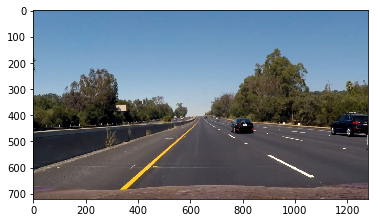

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_video.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))